# Capstone  Project:
## 

### Hyper-parametre tuning and feature selection




LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency
Lower memory usage
Better accuracy
Parallel and GPU learning supported
Capable of handling large-scale data

In [1]:
# Loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, Imputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier, Dataset

import timeit
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# Function for time unit change
def hms (sec):
    sec = round(sec)
    if sec < 60:
        time = str(sec) + ' seconds'
    elif sec < 3600:
        minute = sec // 60
        second = sec % 60
        time = str(minute) + ' minutes ' + str(second) + ' seconds'
    else:
        hour = sec // 3600
        sec = sec % 3600
        minute = sec // 60
        second = sec % 60
        time = str(hour) + ' hours ' + str(minute) + ' minutes' + str(second) + ' seconds'
    return time   

In [3]:
# Function for computing the percent of missing
def missing_perc(data):
    missing_counts = data.isnull().sum()
    return round(missing_counts / len(data) * 100, 1)

# Function for the percent of target == 1 among missing
def missing_target_perc(data, target):
    idx = np.where(data.isnull() & target)
    idx_na = np.where(data.isnull())
    if len(idx_na[0]) == 0:
        return 0.0
    else:
        return round(len(idx[0]) / len(idx_na[0]) * 100, 1)
    
# Function for the percent of target == 1 among no-missing
def no_missing_target_perc(data, target):
    idx = np.where((data.isnull() == 0) & target)
    idx_no_na = np.where(data.isnull() == 0)
    return round(len(idx[0]) / len(idx_no_na[0]) * 100, 1)

In [4]:
# Function for the percent of missing
def get_na_percent(data):
    missing_percs = []
    
    for var in data.columns: 
        missing_percs.append(np.sum(data[var].isnull()) / len(data[var]) * 100)

    na_per_df = pd.DataFrame({'variable': data.columns, 'na_percent': missing_percs})
    return na_per_df.set_index('variable')

In [5]:
# Function for Chi-square test
def chi_sq_test(data, target):
    """ Find any significant diffence in target values ("No_risk" or "Risk") 
        between missing and non-missing groups of data """
    
    # Contegency table
    cross_tab = pd.crosstab(data.isnull(), target)
    cross_tab.columns = ['No_risk', 'Risk']
    cross_tab.index = ['No_missing', 'Missing']
    cross_tab['prob'] = cross_tab.Risk / (cross_tab.No_risk + cross_tab.Risk)
    ct = cross_tab[['No_risk', 'Risk']] # table without prob column   
    
    # Probabilities of 'Risk' for no-missing, missing and population
    no_na_p = cross_tab.prob[0]
    na_p = cross_tab.prob[1]
    pop_p = target_frac
    
    # Chi-squre statistic
    observed = ct.Risk
    expected = ct.sum(axis = 1) * pop_p
    chi_sq = ((observed - expected) ** 2 / expected).sum().sum()
    
    # Margin-of-error, 95% confidence interva and p-vlaue
    se = np.sqrt(np.sum([no_na_p * (1 - no_na_p) / ct.sum(axis = 1)[0], 
                         na_p * (1 - na_p) / ct.sum(axis = 1)[1]]))
    margin_of_error = stats.norm.ppf(.975) * se
    conf_int_95 = [pop_p - margin_of_error, pop_p + margin_of_error]
    p = 1 - stats.chi2.cdf(chi_sq, df = 1)
    
    return(p)

In [6]:
# Loading data
application = pd.read_csv('data/application_train.csv')
cc_bal = pd.read_csv('data/credit_card_balance.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_bal = pd.read_csv('data/bureau_balance.csv')
inst_payment = pd.read_csv('data/installments_payments.csv')
pos_bal = pd.read_csv('data/POS_CASH_balance.csv')

# Check the number of rows and columns 
print('Application data: {}'.format(application.shape), 
      '\nCredit card data: {}'.format(cc_bal.shape),
      '\nBureau data: {}'.format(bureau.shape),
      '\nBureau balance data: {}'.format(bureau_bal.shape),
      '\nInstallments payment data: {}'.format(inst_payment.shape), 
      '\nPOS cash balance data: {}'.format(pos_bal.shape))

Application data: (307511, 122) 
Credit card data: (3840312, 23) 
Bureau data: (1716428, 17) 
Bureau balance data: (27299925, 3) 
Installments payment data: (13605401, 8) 
POS cash balance data: (10001358, 8)


## Application Data

In [7]:
# First five rows of application
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Frequencies of TARGET
target_counts = application.TARGET.value_counts(dropna = False)
target_frac = target_counts[1] / len(application.TARGET) 
target_perc = round(target_counts[1] / len(application.TARGET) * 100, 1)
print('Target counts: \n', target_counts, '\n\nTarget percent:', target_perc )

Target counts: 
 0    282686
1     24825
Name: TARGET, dtype: int64 

Target percent: 8.1


In [9]:
# Frequencies of catrgorical variables
print(application.NAME_CONTRACT_TYPE.value_counts(dropna = False),
     '\n\n', application.CODE_GENDER.value_counts(dropna = False),
     '\n\n', application.FLAG_OWN_CAR.value_counts(dropna = False),
     '\n\n', application.FLAG_OWN_REALTY.value_counts(dropna = False))

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64 

 F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64 

 N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64 

 Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


### Outliers

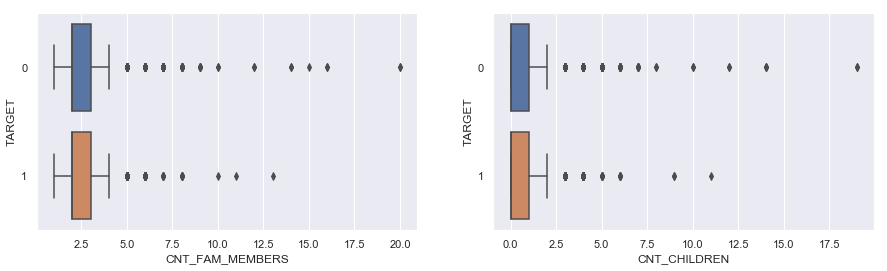

In [10]:
# Family size
sns.set()
f, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(x = 'CNT_FAM_MEMBERS', y = 'TARGET', orient = 'h', data = application, ax = axes[0])
sns.boxplot(x = 'CNT_CHILDREN', y = 'TARGET', orient = 'h', data = application, ax = axes[1])
plt.show()

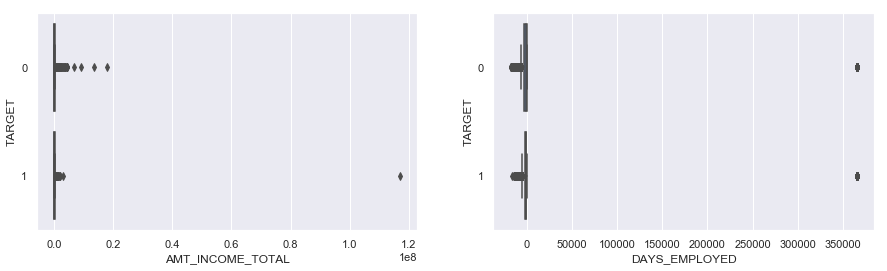

In [11]:
# Boxplots of monthly income and length of emplyeement [0]
sns.set()
f, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(x = 'AMT_INCOME_TOTAL', y = 'TARGET', orient = 'h', data = application, ax = axes[0])
sns.boxplot(x = 'DAYS_EMPLOYED', y = 'TARGET', orient = 'h', data = application, ax = axes[1])
#plt.savefig('Boxplots of income and employment length.png')
plt.show()

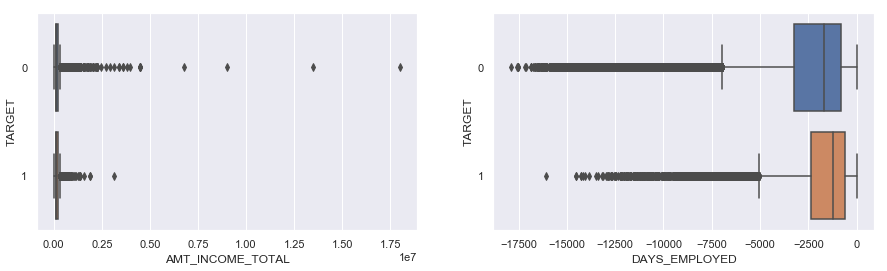

In [12]:
# Replace the income outlier with null
high_incomes = application[application.AMT_INCOME_TOTAL > 100000000]
application.loc[application.AMT_INCOME_TOTAL > 100000000, 'AMT_INCOME_TOTAL'] = np.nan

# Replace the positive number of  days of employments with null
application.loc[application.DAYS_EMPLOYED > 0, 'DAYS_EMPLOYED'] = np.nan

# Boxplots of monthly income and length of emplyeement [1]
sns.set()
f, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(x = 'AMT_INCOME_TOTAL', y = 'TARGET', orient = 'h', data = application, ax = axes[0])
sns.boxplot(x = 'DAYS_EMPLOYED', y = 'TARGET', orient = 'h', data = application, ax = axes[1])
plt.show()

In [13]:
# Columns of days
day_cols = [col for col in application.columns if 'DAYS' in col]
day_cols

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

In [14]:
# Summary of these columns for train
application[day_cols].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,252137.000000,307511.000000,307511.000000,307510.000000
mean,-16036.995067,-2384.169325,-4986.120328,-2994.202373,-962.858788
std,4363.988632,2338.360162,3522.886321,1509.450419,826.808487
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000,-4292.000000
25%,-19682.000000,-3175.000000,-7479.500000,-4299.000000,-1570.000000
50%,-15750.000000,-1648.000000,-4504.000000,-3254.000000,-757.000000
75%,-12413.000000,-767.000000,-2010.000000,-1720.000000,-274.000000
max,-7489.000000,0.000000,0.000000,0.000000,0.000000


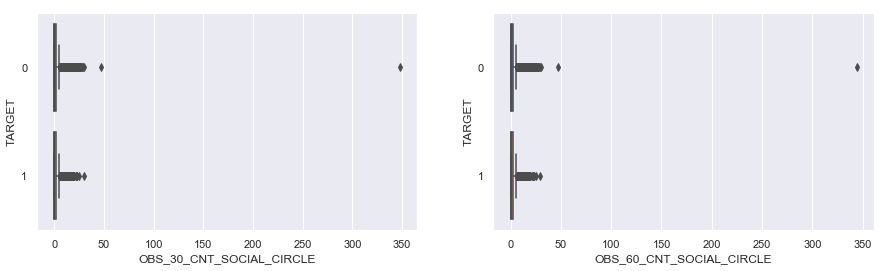

In [15]:
# Boxplots of social circles [0]
sns.set()
f, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(x = 'OBS_30_CNT_SOCIAL_CIRCLE', y = 'TARGET', orient = 'h', 
            data = application, ax = axes[0])
sns.boxplot(x = 'OBS_60_CNT_SOCIAL_CIRCLE', y = 'TARGET', orient = 'h', 
            data = application, ax = axes[1])
plt.show()

In [16]:
# Check the values
larg_sco = application[application.OBS_30_CNT_SOCIAL_CIRCLE > 50]
larg_sco.OBS_60_CNT_SOCIAL_CIRCLE.value_counts()

344.0    1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

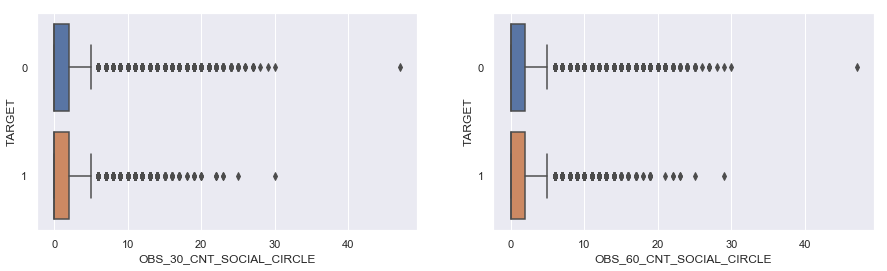

In [17]:
# replace this value with null
application.loc[application.OBS_30_CNT_SOCIAL_CIRCLE > 50, 
                ['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']] = np.nan

# Boxplots of social circles [1]
sns.set()
f, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(x = 'OBS_30_CNT_SOCIAL_CIRCLE', y = 'TARGET', orient = 'h', 
            data = application, ax = axes[0])
sns.boxplot(x = 'OBS_60_CNT_SOCIAL_CIRCLE', y = 'TARGET', orient = 'h', 
            data = application, ax = axes[1])
plt.show()

### There are some variables with large missing values - so check these

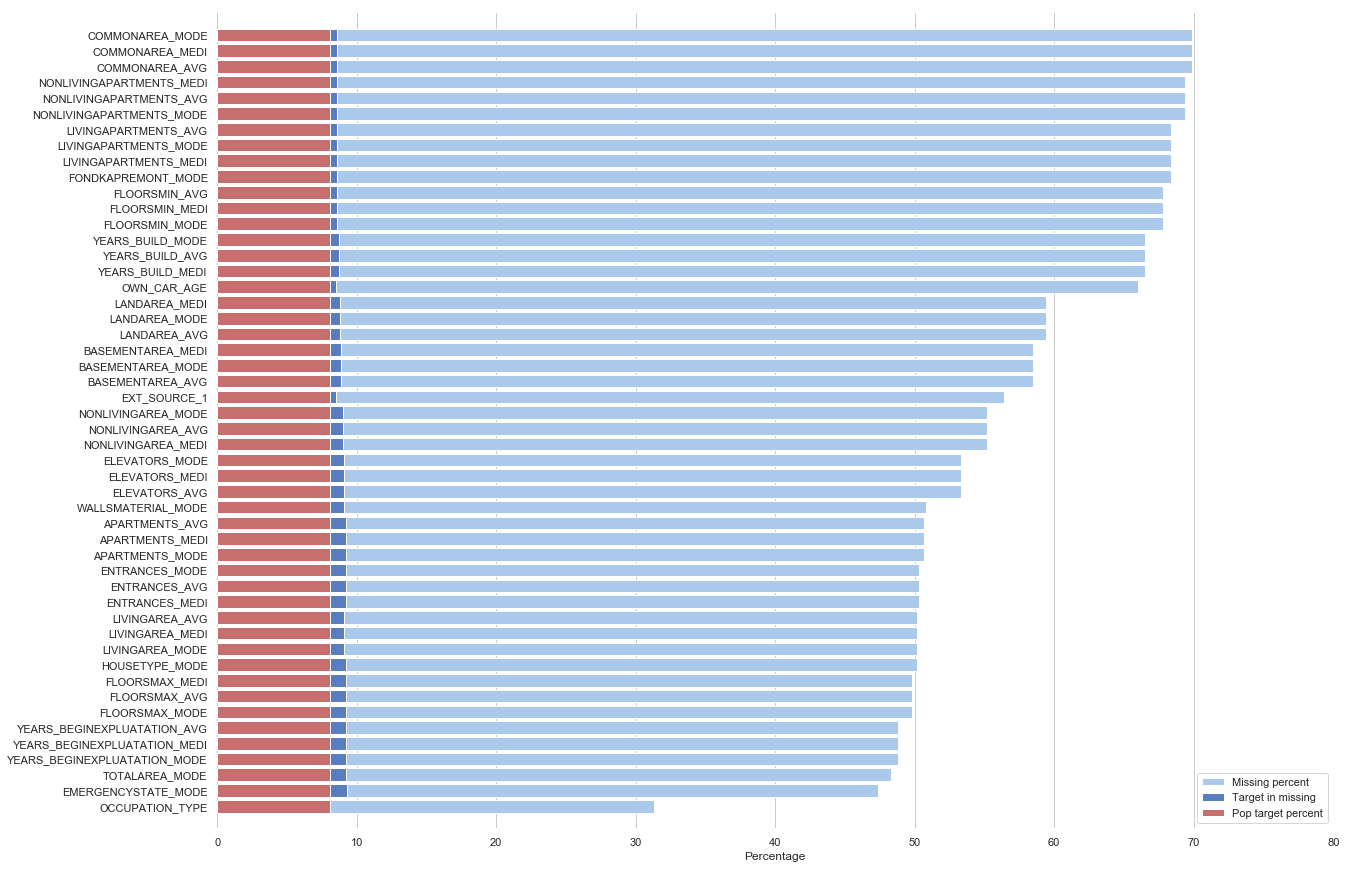

In [18]:
# Missing-value, target == 1 among missing, target == 1 among no-missing percents
app_data = application.drop('TARGET', axis = 1) # drop TARGET column
app_target = application.TARGET # only TARGET column
ms_percs = np.empty(len(app_data.columns)) # initialise array for missing
ms_tg_percs = np.empty(len(app_data.columns)) # initialise for msiing and target
no_ms_tg_percs = np.empty(len(app_data.columns)) # initialise for no-msiing and target
i = -1

for col in app_data.columns:
    i += 1
    data = app_data[col]
    ms_percs[i] = missing_perc(data)
    ms_tg_percs[i] = missing_target_perc(data, app_target)
    no_ms_tg_percs[i] = no_missing_target_perc(data, app_target)
    
na_percent_df = pd.DataFrame({'variable': app_data.columns,
                              'na_percent': ms_percs,
                              'na_target_percent': ms_tg_percs,
                              'no_na_target_percent': no_ms_tg_percs})
na_percent_df = na_percent_df[['variable', 'na_percent', 'na_target_percent', 'no_na_target_percent']]
na_percent_df = na_percent_df.sort_values(by = ['na_percent'], ascending = False)

# Visualise the most missing variables with its percent and target percent
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (20, 15)) # initialise the matplot plane

# New column indication the the total TARGET percent
na_percent_df['target_percent'] = target_perc 

# Plot missing percent
_ = sns.set_color_codes('pastel')
_ = sns.barplot(x = 'na_percent', y = 'variable', data = na_percent_df[:50], 
                label = 'Missing percent', color = 'b')

# Plot percent of TARGET == 1 among missing
_ = sns.set_color_codes('muted')
_ = sns.barplot(x = 'na_target_percent',  y = 'variable', data = na_percent_df[:50], 
                label = 'Target in missing', color = 'b')

# Plot percent of TARGET == 1 among missing
_ = sns.set_color_codes('muted')
_ = sns.barplot(x = 'target_percent',  y = 'variable', data = na_percent_df[:50], 
                label = 'Pop target percent', color = 'r')

# Add a legend and informative axis label
ax.legend(ncol = 1, loc = "lower right", frameon = True)
ax.set(xlim =(0, 80), ylabel = "",
       xlabel = "Percentage")
sns.despine(left = True, bottom = True)
plt.margins(.02)
plt.show()

In [19]:
# Compute p-values of Chi-squre tests
df_missing = na_percent_df.loc[na_percent_df.na_percent > 0]
chi_sq_p = np.empty(len(df_missing.variable)) # initialise array

for i in range(len(df_missing.variable)):
    col = list(df_missing.variable)[i]
    data = app_data[col]
    chi_sq_p[i] = chi_sq_test(data, app_target)
    
chi_sq_p = pd.DataFrame(chi_sq_p)
chi_sq_p.columns = ['p_value']
chi_sq_p.index = df_missing.variable
sig_na_cols =  list(chi_sq_p[chi_sq_p.p_value <= .05].index)

# p-values less than 0.05
print('p_value of less than 0.05: {}'.format(sum(chi_sq_p.p_value <= .05)),
      '\nTotal missing: {}'.format(len(chi_sq_p.p_value)),
      '\nPercent of significance: {}'.format(round(sum(chi_sq_p.p_value <= .05)\
                                                   /len(chi_sq_p.p_value) * 100, 2)))

p_value of less than 0.05: 63 
Total missing: 65 
Percent of significance: 96.92


In [20]:
# Compute the correlation matrix for train data
corr = application.drop('SK_ID_CURR', axis = 1).corr()
corr.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
TARGET,1.000000,0.019187,-0.020460,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,0.074958,0.041975,...,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,0.019187,1.000000,0.025254,0.002145,0.021374,-0.001827,-0.025573,0.330938,0.061145,0.183395,...,0.004031,0.000864,0.000988,-0.002450,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550
AMT_INCOME_TOTAL,-0.020460,0.025254,1.000000,0.342170,0.417884,0.348698,0.165577,0.056669,-0.032221,0.062354,...,0.007137,0.005333,0.000606,-0.001219,0.002058,0.007449,0.006543,0.061472,0.013287,0.030573
AMT_CREDIT,-0.030369,0.002145,0.342170,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.091295,0.009621,...,0.034329,0.021082,0.031023,-0.016148,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,-0.012817,0.021374,0.417884,0.770138,1.000000,0.775109,0.118429,0.009445,-0.053604,0.038514,...,-0.009745,0.004573,0.011718,-0.017598,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320


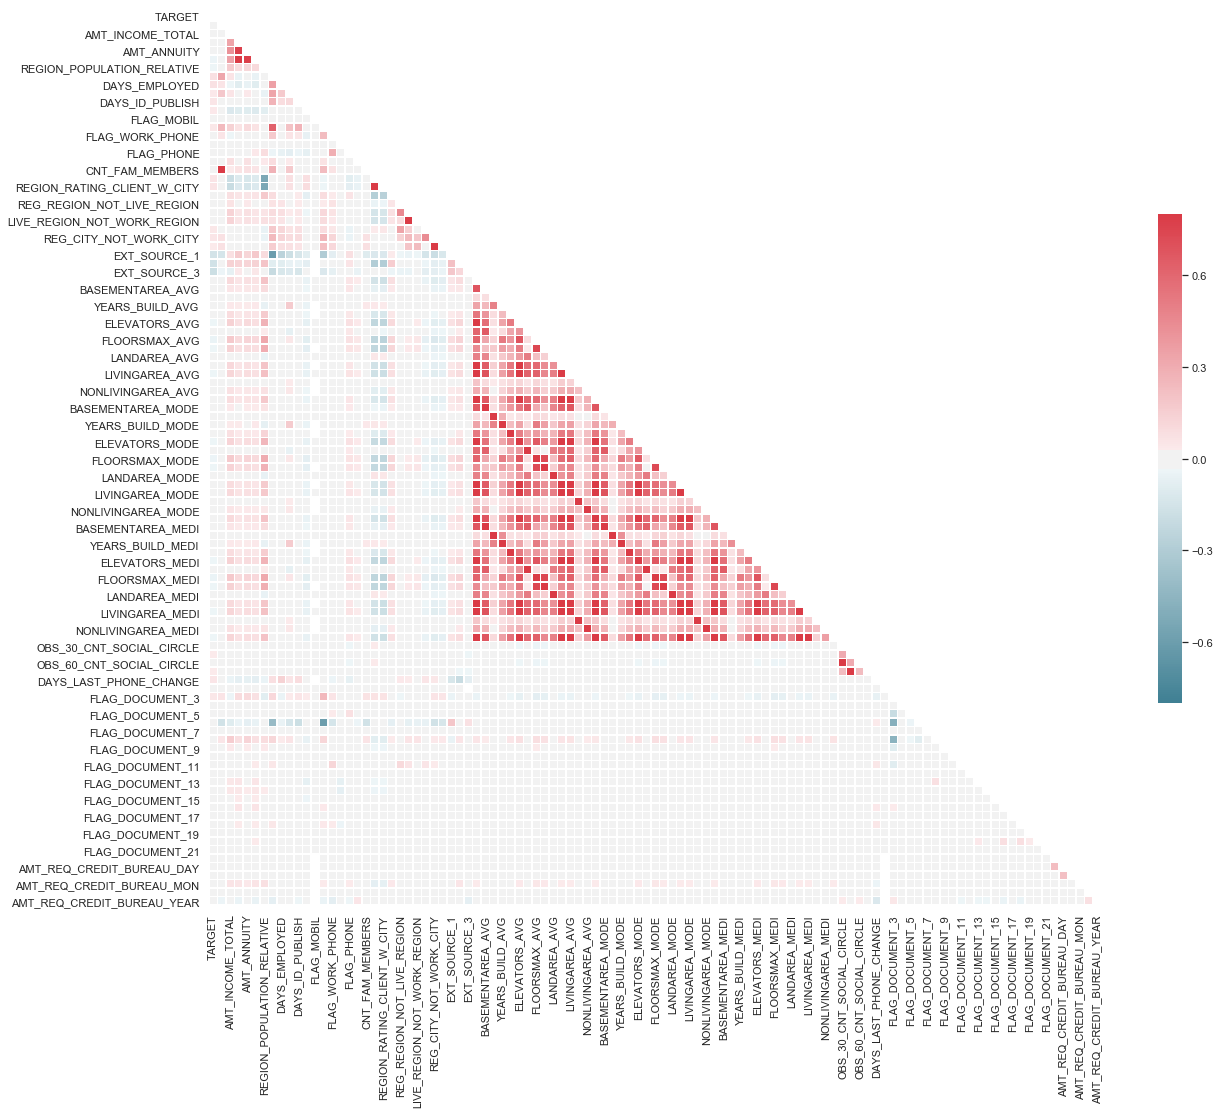

In [21]:
# Plot heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
f, ax = plt.subplots(figsize = (20, 18))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -0.8, vmax=0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
plt.show()

In [22]:
# Implement missing indicator columns for the application data
for col in sig_na_cols: # add columns for train
    col_name = col + '_na'
    application[col_name] = application[col].isnull()

print('Application rows and columns: {}'.format(application.shape))

Application rows and columns: (307511, 185)


### Credic card balance data

In [23]:
# Sort by current and previous IDs
cc_bal = cc_bal.sort_values(['SK_ID_CURR', 'SK_ID_PREV'])
cc_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
520387,1489396,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
584804,1489396,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
655566,1489396,100006,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,1489396,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,1489396,100006,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


In [24]:
# Missing percentages
get_na_percent(cc_bal).sort_values(by = ['na_percent'], ascending = False).head()

,na_percent
variable,
AMT_PAYMENT_CURRENT,19.998063
AMT_DRAWINGS_ATM_CURRENT,19.524872
CNT_DRAWINGS_POS_CURRENT,19.524872
AMT_DRAWINGS_OTHER_CURRENT,19.524872
AMT_DRAWINGS_POS_CURRENT,19.524872


In [25]:
# Fill missing with zero an dcheck it
cc_bal = cc_bal.fillna(0)
np.sum(get_na_percent(cc_bal))

na_percent    0.0
dtype: float64

In [26]:
# Aggregation
start = timeit.default_timer()
# List of current IDs
curr_ids = cc_bal.SK_ID_CURR.unique()

# Empty lists
CCB_card_counts = np.empty(len(curr_ids))       
CCB_record_counts = np.empty(len(curr_ids))     
CCB_draw_count_mean = np.empty(len(curr_ids))  
CCB_bal_mean = np.empty(len(curr_ids))          
CCB_diff_limit_draw = np.empty(len(curr_ids))   
CCB_tot_receivable = np.empty(len(curr_ids))   
CCB_delay_days_mean = np.empty(len(curr_ids))  

# Compute
for i in range(len(curr_ids)):
    cid = curr_ids[i]
    subset = cc_bal[cc_bal.SK_ID_CURR == cid]
    CCB_card_counts[i] = subset.SK_ID_PREV.nunique()
    CCB_record_counts[i] = len(subset.MONTHS_BALANCE)
    CCB_draw_count_mean[i] = np.mean(subset.CNT_DRAWINGS_CURRENT)
    CCB_bal_mean[i] = np.mean(subset.AMT_BALANCE)
    CCB_diff_limit_draw[i] = np.mean(subset.AMT_CREDIT_LIMIT_ACTUAL  - subset.AMT_DRAWINGS_CURRENT)
    CCB_tot_receivable[i] = np.sum(subset.AMT_RECIVABLE)
    CCB_delay_days_mean[i] = np.mean(subset.SK_DPD)

cc_bal_agg = pd.DataFrame({'SK_ID_CURR': curr_ids,
                           'CCB_card_counts': CCB_card_counts,
                           'CCB_record_counts': CCB_record_counts,
                           'CCB_draw_count_mean': CCB_draw_count_mean,
                           'CCB_bal_mean': CCB_bal_mean,
                           'CCB_diff_limit_draw': CCB_diff_limit_draw,
                           'CCB_tot_receivable': CCB_tot_receivable,
                           'CCB_delay_days_mean': CCB_delay_days_mean})
stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 45 minutes 32 seconds


In [27]:
# First few rows of the aggregated data
cc_bal_agg.head()

,CCB_bal_mean,CCB_card_counts,CCB_delay_days_mean,CCB_diff_limit_draw,CCB_draw_count_mean,CCB_record_counts,CCB_tot_receivable,SK_ID_CURR
0,0.000000,1.0,0.000000,270000.000000,0.000000,6.0,0.000,100006
1,54482.111149,1.0,0.000000,161756.756757,0.054054,74.0,4028055.255,100011
2,18159.919219,1.0,0.010417,125765.625000,0.239583,96.0,1737703.665,100013
3,0.000000,1.0,0.000000,675000.000000,0.000000,17.0,0.000,100021
4,0.000000,1.0,0.000000,135000.000000,0.000000,8.0,0.000,100023


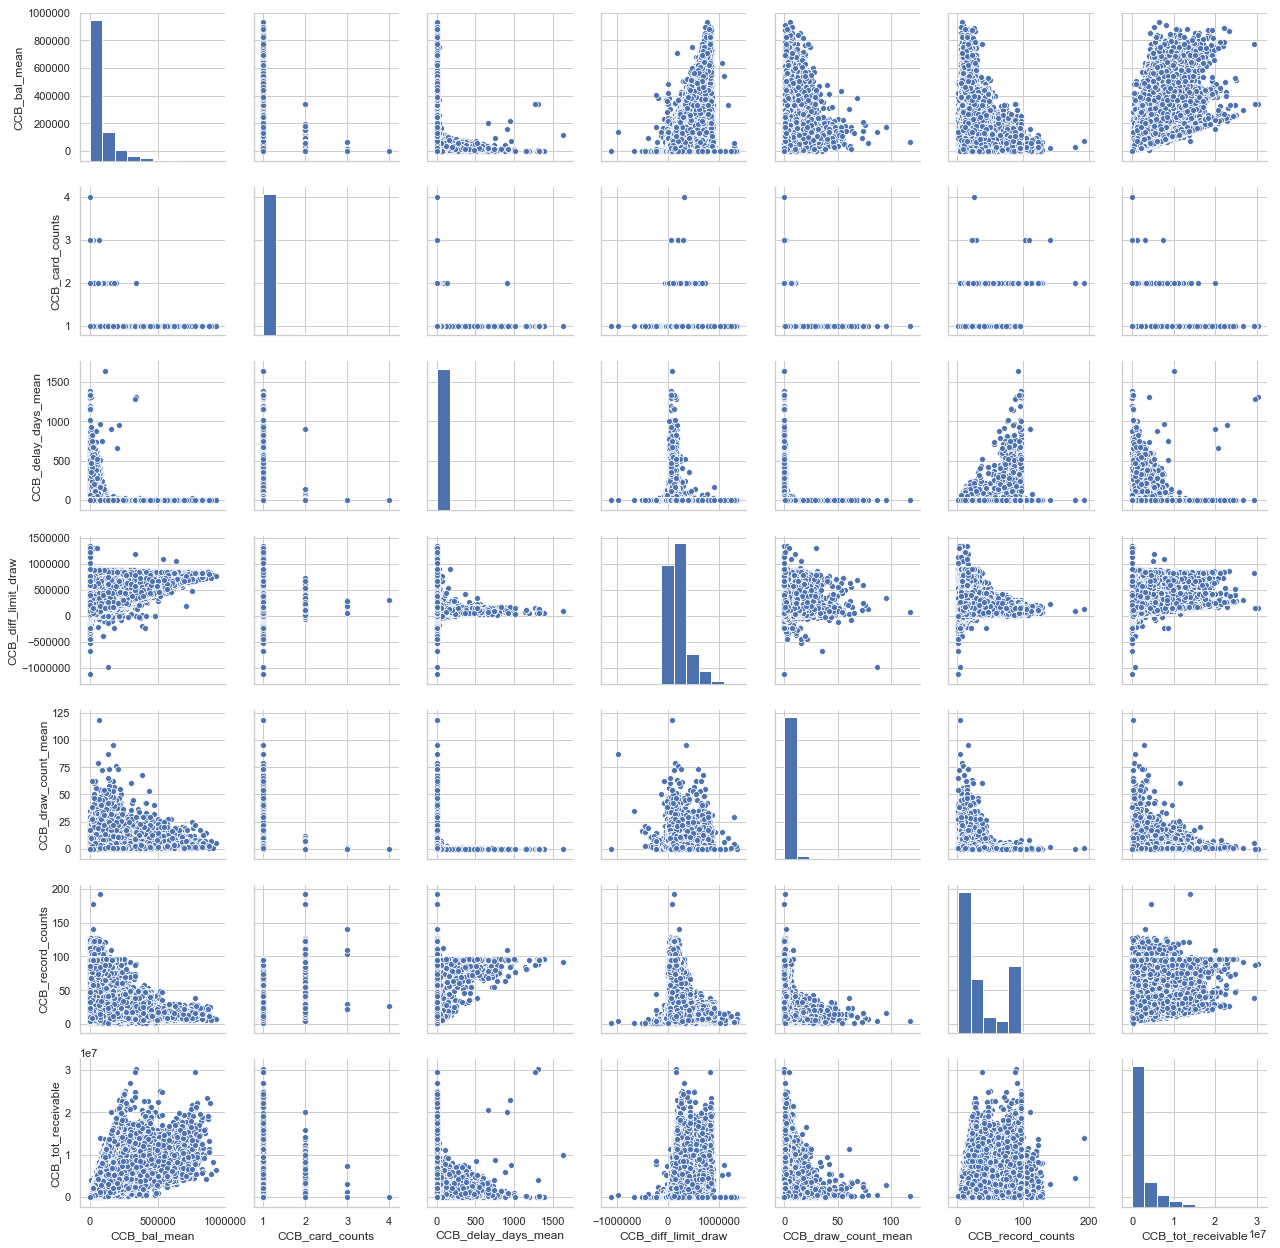

In [28]:
# Outlook of each pair
sns.pairplot(cc_bal_agg.drop('SK_ID_CURR', axis = 1))
plt.show()

In [29]:
# Print number of cards that were previously assigned to each customer
cc_bal_agg.CCB_card_counts.value_counts()

1.0    102818
2.0       732
3.0         7
4.0         1
Name: CCB_card_counts, dtype: int64

In [30]:
# Check delay days for only positive values
delay_days = cc_bal_agg.CCB_delay_days_mean[cc_bal_agg.CCB_delay_days_mean > 0]
delay_days.describe()

count    20660.000000
mean        20.587320
std         97.551369
min          0.007937
25%          0.023256
50%          0.083333
75%          0.461538
max       1635.684783
Name: CCB_delay_days_mean, dtype: float64

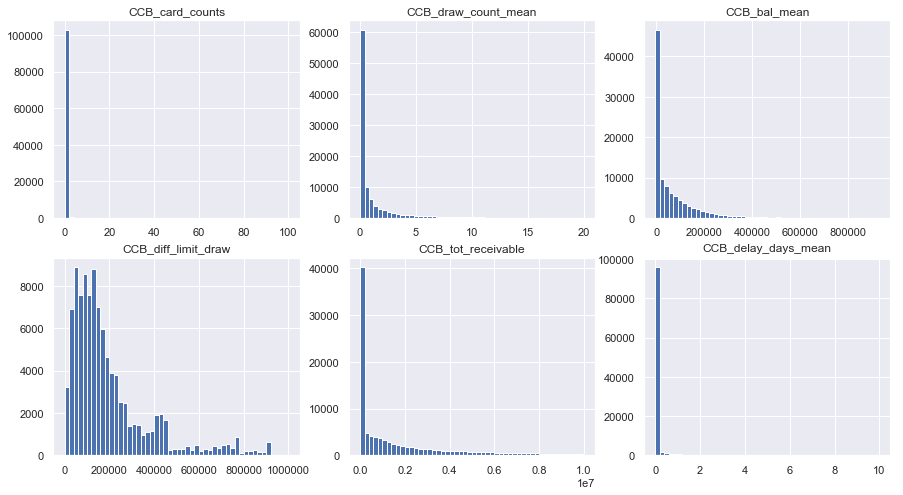

In [31]:
# Histograms
sns.set()
f, axes = plt.subplots(2, 3, figsize = (15, 8))

axes[0,0].hist(cc_bal_agg.CCB_card_counts, range = (0, 100), bins = 50)
axes[0,0].set_title('CCB_card_counts')
axes[0,1].hist(cc_bal_agg.CCB_draw_count_mean, range = (0, 20), bins = 50)
axes[0,1].set_title('CCB_draw_count_mean')
axes[0,2].hist(cc_bal_agg.CCB_bal_mean, bins = 50)
axes[0,2].set_title('CCB_bal_mean')
axes[1,0].hist(cc_bal_agg.CCB_diff_limit_draw, range = (0, 1000000), bins = 50)
axes[1,0].set_title('CCB_diff_limit_draw')
axes[1,1].hist(cc_bal_agg.CCB_tot_receivable, range = (0, 10000000), bins = 50)
axes[1,1].set_title('CCB_tot_receivable')
axes[1,2].hist(cc_bal_agg.CCB_delay_days_mean, range = (0, 10), bins = 50)
axes[1,2].set_title('CCB_delay_days_mean')

plt.show()

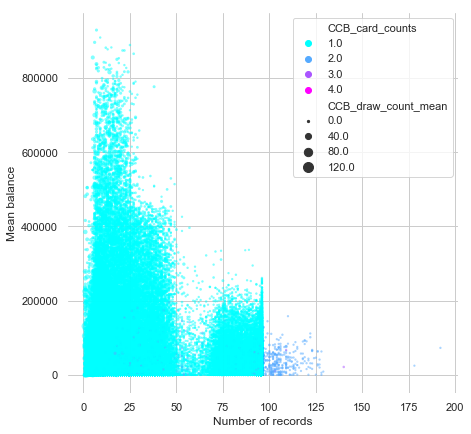

In [32]:
# Scatter plot of mean-balance vs. num-balance-records
# with hue for mean-draw-count and size for num-previous-cards
sns.set(style = 'whitegrid')
f,ax = plt.subplots(figsize = (7, 7))
sns.despine(f, left = True, bottom = True)
sns.scatterplot(x = 'CCB_record_counts', y = 'CCB_bal_mean', 
                hue = 'CCB_card_counts', size = 'CCB_draw_count_mean',
                palette="cool", sizes = (5, 100), alpha = .5,
                data = cc_bal_agg, linewidth = 0, ax =ax)
plt.xlabel('Number of records')
plt.ylabel('Mean balance')
plt.show()

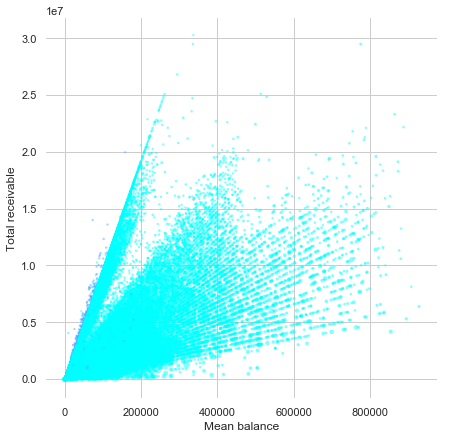

In [33]:
# Scatter plot of sum-receivables vs. mean-balance 
# with hue for mean-draw-count and size for num-previous-cards
sns.set(style = 'whitegrid')
f,ax = plt.subplots(figsize = (7, 7))
sns.despine(f, left = True, bottom = True)
sns.scatterplot(x = 'CCB_bal_mean', y = 'CCB_tot_receivable',
                hue = 'CCB_card_counts', size = 'CCB_draw_count_mean',
                palette="cool", sizes = (5, 100), alpha = .5,
                data = cc_bal_agg, linewidth = 0, ax =ax)
plt.xlabel('Mean balance')
plt.ylabel('Total receivable')
plt.legend().set_visible(False)
plt.show()

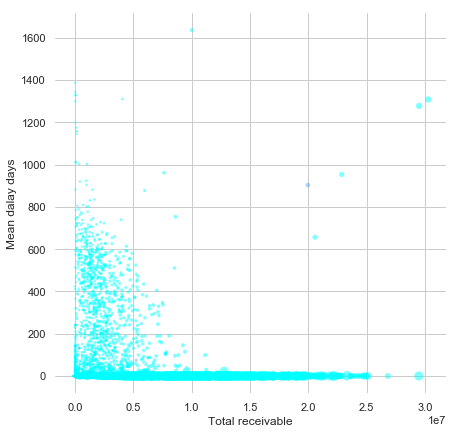

In [34]:
# Scatter plot of  mean-delay-days vs. sum-receivables 
# with hue for mean-draw-count and size for mean-balance
sns.set(style = 'whitegrid')
f,ax = plt.subplots(figsize = (7, 7))
sns.despine(f, left = True, bottom = True)
sns.scatterplot(x = 'CCB_tot_receivable',y = 'CCB_delay_days_mean',
                hue = 'CCB_card_counts', size = 'CCB_bal_mean',
                palette="cool", sizes = (5, 100), alpha = .5,
                data = cc_bal_agg, linewidth = 0, ax =ax)
plt.xlabel('Total receivable')
plt.ylabel('Mean dalay days')
plt.legend().set_visible(False)
plt.show()

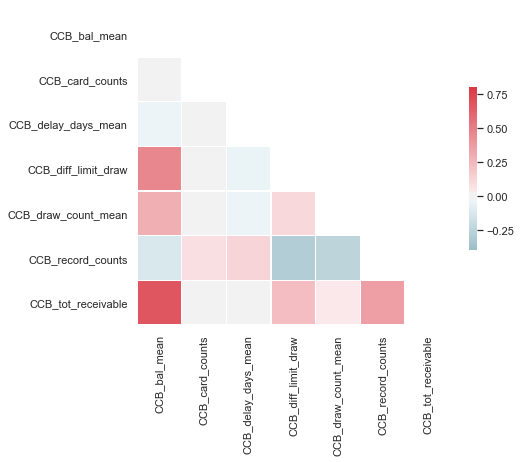

In [35]:
# Correlation matrix
corr = cc_bal_agg.drop('SK_ID_CURR', axis = 1).corr()

# Plot heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
f, ax = plt.subplots(figsize = (7, 6))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,vmin = -.4, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
plt.show()

Aggregation process for each applicant takes a bit of time - about 10.5 minutes. After the long wait, we have 103558 rows and eight columns in our new data table. First, as we want to overlook the new data, we apply pair-plot using seaborn module. There seem to be only-one-column histograms for the number of cards, the mean of the number of monthly draws and the mean of delays in days. From histograms of individual variables we can see that most people have had one credit card, use credit card no more than five times a month, hardly delay their payments. 
We apply to scatter plot to see the relationship between the number of records and the mean balance (the first scatter plot) - interestingly, people have more records have less balance; the colour of the points represents the number of cards - but the most points coloured with bright blue as over 90% of people have only one. It is hard to see the size of dots as the most people use the card less than five times a month. The second scatter plot shows that the mean balance has a positive relationship with the total of receivables. On the other hands, we cannot find much information from the third scatter plot.
We produce the correlation matrix and heat map - the mean of balances and the sum of receivables have the strongest correlation with the Pearson's coefficient of 0.67.
### Aggregate data in backward-time

In [36]:
# List of current IDs
time_ids = cc_bal.MONTHS_BALANCE.unique()

# Empty list for storing the number of previous credit cards
record_counts = np.empty(len(time_ids))     # length of record 
draw_count_mean = np.empty(len(time_ids))   # mean of the montly drawings
bal_mean = np.empty(len(time_ids))          # mean of teh monthly balance
diff_limit_draw = np.empty(len(time_ids))   # mean of defferences between limit and draw
delay_days_mean = np.empty(len(time_ids))   # Mean of delayed payments in days

# Count the number of cards
for i in range(len(time_ids)):
    tid = time_ids[i]
    subset = cc_bal[cc_bal.MONTHS_BALANCE == tid]
    record_counts[i] = len(subset.SK_ID_CURR)
    draw_count_mean[i] = np.mean(subset.CNT_DRAWINGS_CURRENT)
    bal_mean[i] = np.mean(subset.AMT_BALANCE)
    diff_limit_draw[i] = np.mean(subset.AMT_CREDIT_LIMIT_ACTUAL  - subset.AMT_DRAWINGS_CURRENT)
    delay_days_mean[i] = np.mean(subset.SK_DPD)

cc_bal_time = pd.DataFrame({'MONTHS': time_ids,
                           'CNT_CC_BAL_RECORDS': record_counts,
                           'MEAN_DRAW_COUNT': draw_count_mean,
                           'MEAN_BALANCE': bal_mean,
                           'MEAN_DIFF_LIMIT_DRAW': diff_limit_draw,
                           'MEAN_DELAY_DAYS': delay_days_mean})
cc_bal_time = cc_bal_time[['MONTHS', 'CNT_CC_BAL_RECORDS','MEAN_DRAW_COUNT',
                           'MEAN_BALANCE', 'MEAN_DIFF_LIMIT_DRAW', 'MEAN_DELAY_DAYS']]

# Sort data by time
cc_bal_time = cc_bal_time.sort_values('MONTHS')
cc_bal_time.head()

,MONTHS,CNT_CC_BAL_RECORDS,MEAN_DRAW_COUNT,MEAN_BALANCE,MEAN_DIFF_LIMIT_DRAW,MEAN_DELAY_DAYS
85,-96,11722.0,0.543337,63434.466623,111113.277731,0.393278
89,-95,12521.0,0.492133,63763.446413,112441.305531,0.384314
81,-94,13397.0,0.516757,64443.613043,111990.234034,0.434948
93,-93,14197.0,0.525393,65817.713607,112142.215225,0.438825
83,-92,14911.0,0.490108,66583.989138,113108.478381,0.418952


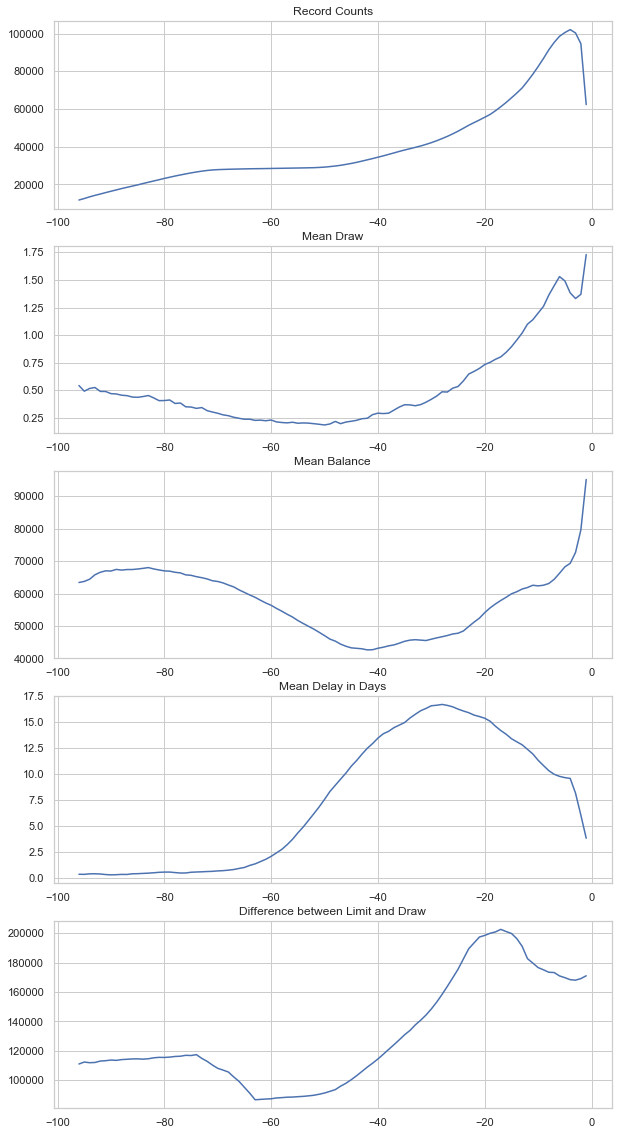

In [37]:
# Time-series plots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
x = cc_bal_time.MONTHS

axes[0].plot(x, cc_bal_time.CNT_CC_BAL_RECORDS)
axes[0].set_title('Record Counts')
axes[1].plot(x, cc_bal_time.MEAN_DRAW_COUNT)
axes[1].set_title('Mean Draw')
axes[2].plot(x, cc_bal_time.MEAN_BALANCE)
axes[2].set_title('Mean Balance')
axes[3].plot(x, cc_bal_time.MEAN_DELAY_DAYS)
axes[3].set_title('Mean Delay in Days')
axes[4].plot(x, cc_bal_time.MEAN_DIFF_LIMIT_DRAW)
axes[4].set_title('Difference between Limit and Draw')

plt.show()

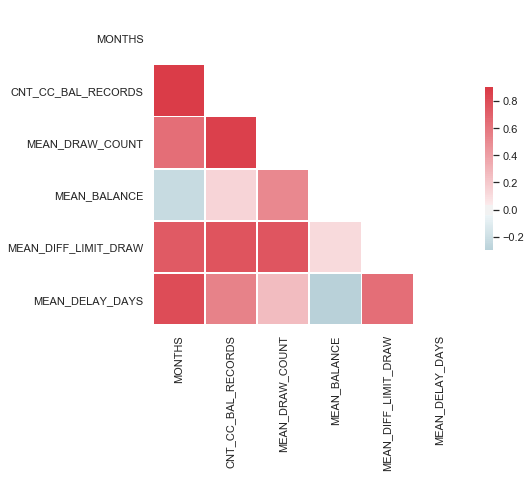

In [38]:
# Correlation 
corr = cc_bal_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (7, 6))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,vmin = -.3, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
plt.show()

Implementing the new table for the timewise aggregation takes just a couple of seconds - comparable to the earlier implementation for each applicant, revoke it was 10.5 minutes. This might be reasoned by the small number ot distinct time stamps, figured 96.
The first time-series plot shows that there is an increaing trend of the number of records until about five months before the applying a loan. The plot of the mean of monthly draws represents a hyperbolic curve until the recent time. Interestingly, the mean of monthly balances has a similar trend with the second plot of the mean monthly draws, except a bit of wavy curve at the early time with having a peak at the time of -85. Comparing these, the plot of the difference between the limit and draw has a curvier shape - this one starts to rise earlier at about -50 and starts to drop from just after -20. On the other hand, the mean of delays in days flats until -60, then shapes parabolic, which has a peak at about -30. From these plots, we can conclude that mean balanbce is dramatically increase from the time of a year before applying for a loan, and the mean of delays seem to drop from the time of two years before applying.
The correlation matrix and heat map represent that the number of records and mean delay days have strong correlations with time. Similarly, the number of draws and the mean difference between the limit and the draw have moderately positive correlations with time.

### Bureau

In [39]:
# Sort by current and previous IDs
bureau = bureau.sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
248484,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248485,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248486,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248487,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248488,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5


In [40]:
# Summary of columns
bureau.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis = 1).describe()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [41]:
# Missing percentages
get_na_percent(bureau).sort_values('na_percent', ascending = False).head()

,na_percent
variable,
AMT_ANNUITY,71.473490
AMT_CREDIT_MAX_OVERDUE,65.513264
DAYS_ENDDATE_FACT,36.916958
AMT_CREDIT_SUM_LIMIT,34.477415
AMT_CREDIT_SUM_DEBT,15.011932


In [42]:
# Check the  outlier of DAYS_CREDIT_UPDATE --> fill with -372
bureau.loc[bureau['DAYS_CREDIT_UPDATE'] == 372]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1287459,438963,5354670,Active,currency 1,-2555,0,4005.0,NaN,0.0,0,7470000.0,7456589.55,0.0,0.0,Mortgage,372,0.0


In [43]:
# Misisng imputation:
# AMT_CREDIT_MAX_OVERDUE --> 0
# AMT_CREDIT_SUM_DEBT --> 0
# AMT_CREDIT_SUM --> median
# DAYS_CREDIT_UPDATE (372 ) --> -372
bureau = bureau[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 
                 'AMT_CREDIT_SUM', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_OVERDUE', 
                 'AMT_CREDIT_MAX_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_CREDIT_SUM_DEBT']]

bureau['AMT_CREDIT_MAX_OVERDUE'] = bureau['AMT_CREDIT_MAX_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)

atm_credit_sum_median = bureau['AMT_CREDIT_SUM'].median()
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(atm_credit_sum_median)
bureau.loc[bureau['DAYS_CREDIT_UPDATE'] == 372, 'DAYS_CREDIT_UPDATE'] = -372
np.sum(get_na_percent(bureau))

na_percent    0.0
dtype: float64

In [44]:
start = timeit.default_timer()
# List of current IDs
curr_ids = bureau.SK_ID_CURR.unique()

# Empty lists
BR_record_counts = np.empty(len(curr_ids))     
BR_days_credit_mean = np.empty(len(curr_ids))       
BR_days_overdue_mean =np.empty(len(curr_ids))
BR_credit_sum_mean = np.empty(len(curr_ids))   
BR_days_prolong_mean = np.empty(len(curr_ids))          
BR_credit_overdue_mean = np.empty(len(curr_ids))   
BR_credit_overdue_max = np.empty(len(curr_ids))   
BR_days_update_max = np.empty(len(curr_ids))    
BR_credit_debt_sum = np.empty(len(curr_ids))   

# Computing
for i in range(len(curr_ids)):
    cid = curr_ids[i]
    subset = bureau[bureau.SK_ID_CURR == cid]
    BR_record_counts[i] = subset.SK_ID_BUREAU.nunique()
    BR_days_credit_mean[i] = np.mean(subset.DAYS_CREDIT)
    BR_days_overdue_mean[i] = np.mean(subset.CREDIT_DAY_OVERDUE)
    BR_credit_sum_mean[i] = np.mean(subset.AMT_CREDIT_SUM)
    BR_days_prolong_mean[i] = np.mean(subset.CNT_CREDIT_PROLONG)
    BR_credit_overdue_mean[i] = np.mean(subset.AMT_CREDIT_SUM_OVERDUE)
    BR_credit_overdue_max[i] = np.max(subset.AMT_CREDIT_MAX_OVERDUE)
    BR_days_update_max[i] = np.max(subset.DAYS_CREDIT_UPDATE)
    BR_credit_debt_sum[i] = np.sum(subset.AMT_CREDIT_SUM_DEBT)
    
bureau_agg = pd.DataFrame({'SK_ID_CURR': curr_ids,
                           'BR_record_counts': BR_record_counts,
                           'BR_days_credit_mean': BR_days_credit_mean,
                           'BR_days_overdue_mean': BR_days_overdue_mean,
                           'BR_credit_sum_mean': BR_credit_sum_mean,
                           'BR_days_prolong_mean': BR_days_prolong_mean,
                           'BR_credit_overdue_mean': BR_credit_overdue_mean,
                           'BR_credit_overdue_max': BR_credit_overdue_max,
                           'BR_days_update_max': BR_days_update_max,
                           'BR_credit_debt_sum': BR_credit_debt_sum})
stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 1 hours 11 minutes12 seconds


In [45]:
# First few rows of the aggregated data
bureau_agg.head()

,BR_credit_debt_sum,BR_credit_overdue_max,BR_credit_overdue_mean,BR_credit_sum_mean,BR_days_credit_mean,BR_days_overdue_mean,BR_days_prolong_mean,BR_days_update_max,BR_record_counts,SK_ID_CURR
0,596686.5,0.000,0.0,207623.571429,-735.000000,0.0,0.0,-6.0,7.0,100001
1,245781.0,5043.645,0.0,108131.945625,-874.000000,0.0,0.0,-7.0,8.0,100002
2,0.0,0.000,0.0,254350.125000,-1400.750000,0.0,0.0,-43.0,4.0,100003
3,0.0,0.000,0.0,94518.900000,-867.000000,0.0,0.0,-382.0,2.0,100004
4,568408.5,0.000,0.0,219042.000000,-190.666667,0.0,0.0,-11.0,3.0,100005


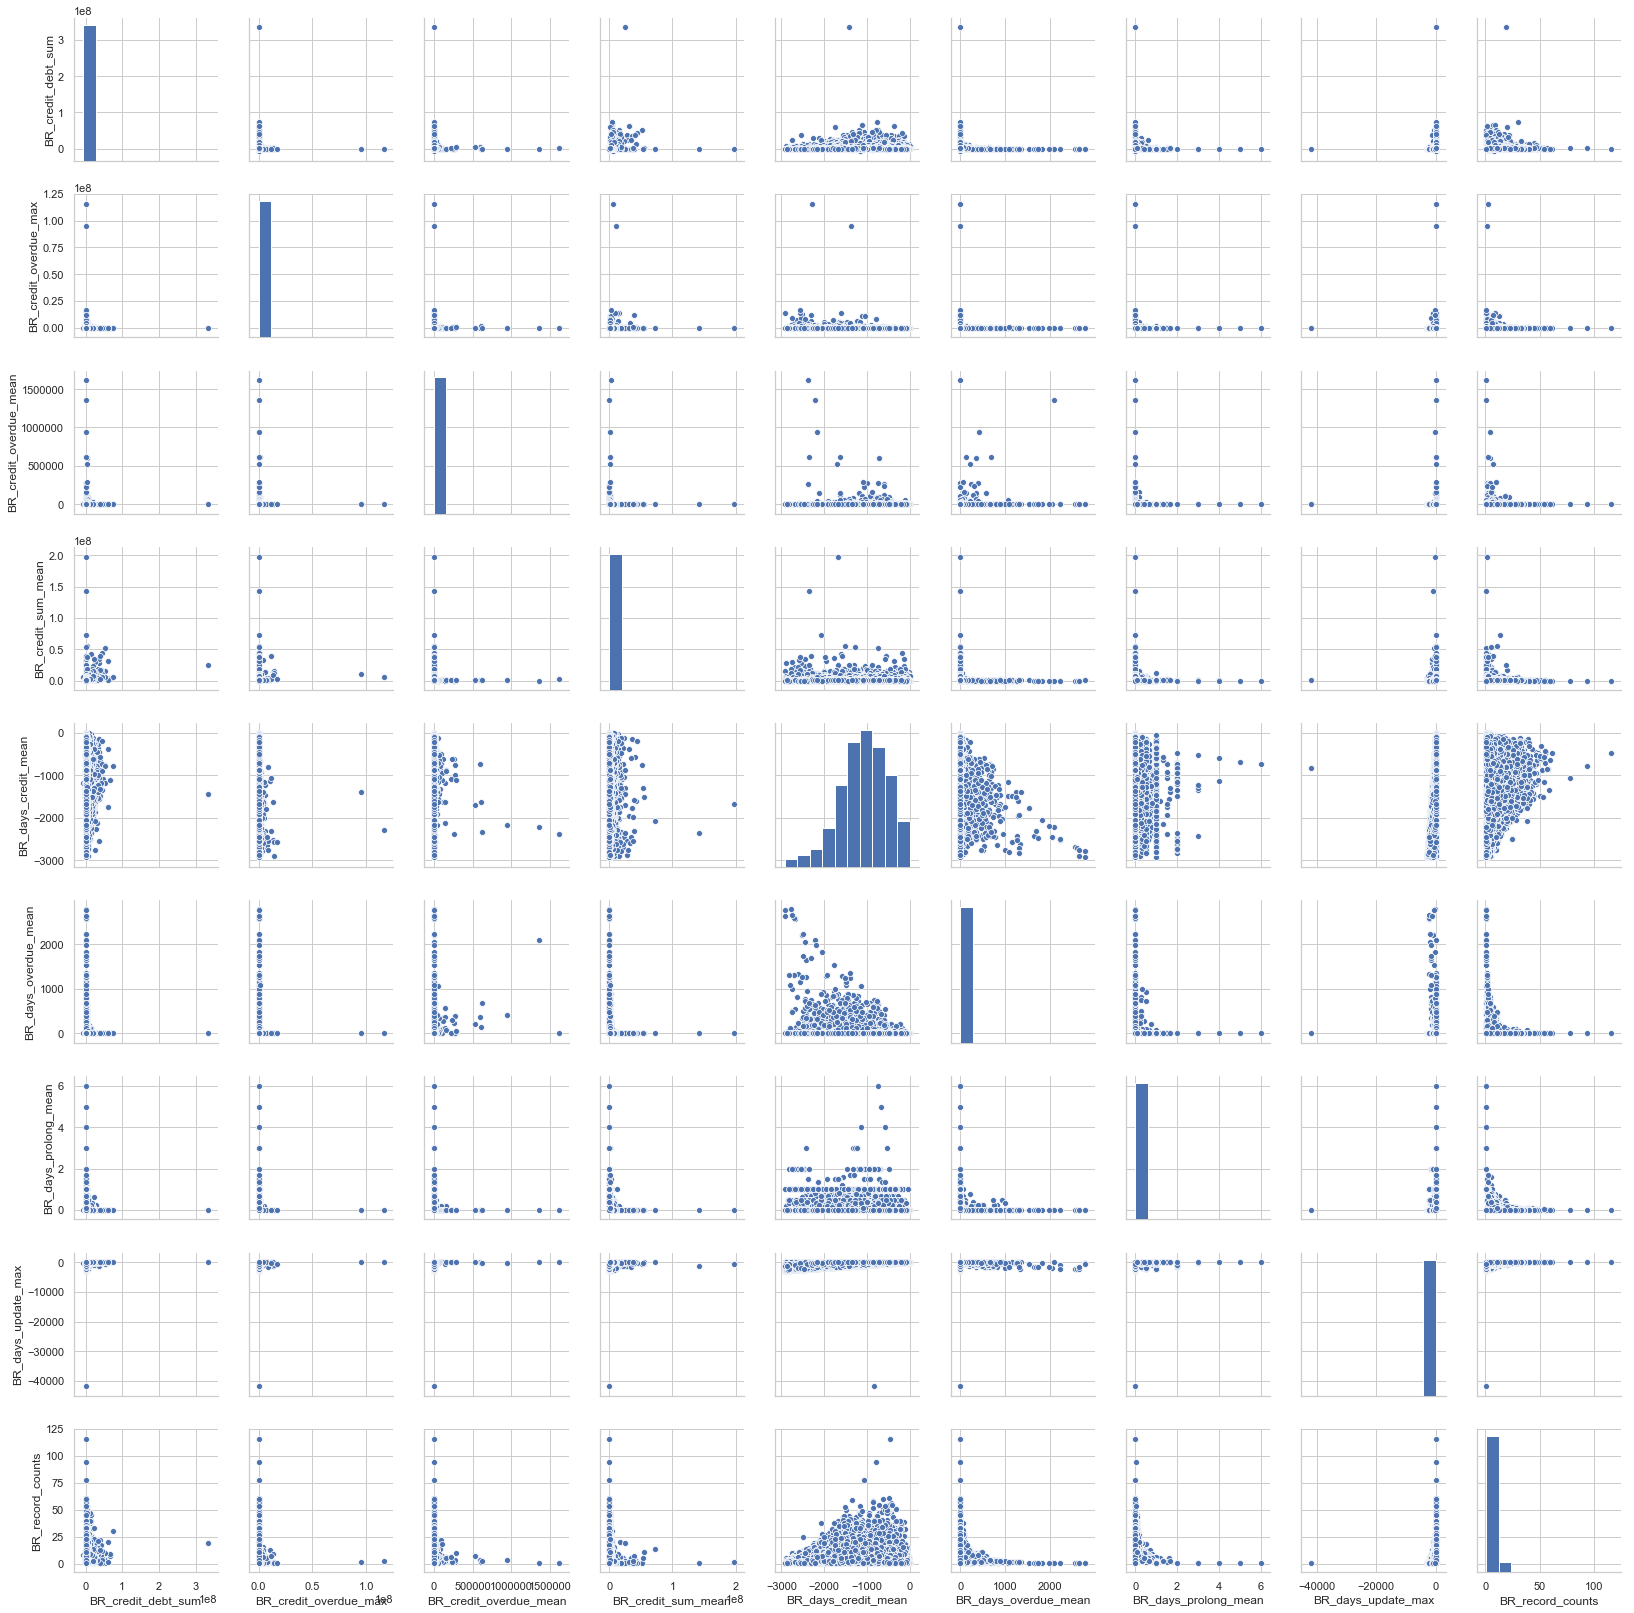

In [46]:
# Outlook of each pair
sns.pairplot(bureau_agg.drop('SK_ID_CURR', axis = 1))
plt.show()

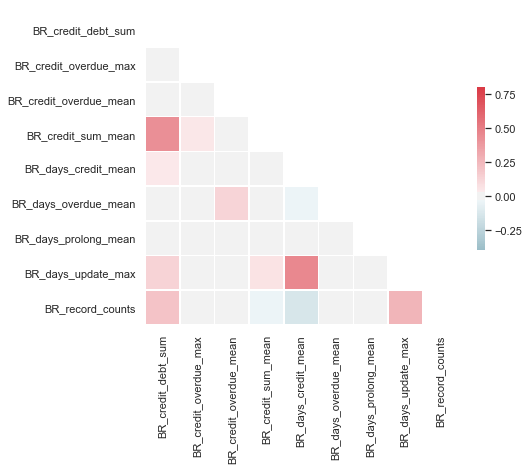

In [47]:
# Correlation matrix
corr = bureau_agg.drop('SK_ID_CURR', axis = 1).corr()

# Plot heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (7, 6))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,vmin = -.4, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
plt.show()

### Bureau balance

In [48]:
# First few rows
bureau_1 = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
bureau_bal = pd.merge(bureau_bal, bureau_1, how = 'left', on = 'SK_ID_BUREAU')
bureau_bal = bureau_bal.sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR
4040588,5896630,0,C,100001.0
4040589,5896630,-1,C,100001.0
4040590,5896630,-2,C,100001.0
4040591,5896630,-3,C,100001.0
4040592,5896630,-4,C,100001.0


In [49]:
# Missing percentages
get_na_percent(bureau_bal).sort_values('na_percent', ascending = False)

,na_percent
variable,
SK_ID_CURR,11.429277
SK_ID_BUREAU,0.000000
MONTHS_BALANCE,0.000000
STATUS,0.000000


In [50]:
# Drop the rows with no SK_ID_CURR
bureau_bal = bureau_bal.dropna(axis = 0)

# Frequencies of categories in STATUS
bureau_bal.STATUS.value_counts()

C    11555429
0     7195282
X     5115090
1      229773
5       50334
2       20954
3        7833
4        5046
Name: STATUS, dtype: int64

In [51]:
# Encoding STATUS
bureau_bal_ec = pd.get_dummies(bureau_bal, prefix = 'status', columns = ['STATUS'], drop_first = True)
bureau_bal_ec.head()

,SK_ID_BUREAU,MONTHS_BALANCE,SK_ID_CURR,status_1,status_2,status_3,status_4,status_5,status_C,status_X
4040588,5896630,0,100001.0,0,0,0,0,0,1,0
4040589,5896630,-1,100001.0,0,0,0,0,0,1,0
4040590,5896630,-2,100001.0,0,0,0,0,0,1,0
4040591,5896630,-3,100001.0,0,0,0,0,0,1,0
4040592,5896630,-4,100001.0,0,0,0,0,0,1,0


In [52]:
# Aggregation
start = timeit.default_timer()
# List of current IDs
curr_ids = bureau_bal_ec.SK_ID_CURR.unique()

# Empty lists
BRB_record_counts = np.empty(len(curr_ids))     
BRB_status_1 =np.empty(len(curr_ids))
BRB_status_2 = np.empty(len(curr_ids))   
BRB_status_3 = np.empty(len(curr_ids))          
BRB_status_4 = np.empty(len(curr_ids))   
BRB_status_5 = np.empty(len(curr_ids))   
BRB_status_C = np.empty(len(curr_ids))    
BRB_status_X = np.empty(len(curr_ids))   

# Computing
for i in range(len(curr_ids)):
    cid = curr_ids[i]
    subset = bureau_bal_ec[bureau_bal_ec.SK_ID_CURR == cid]
    BRB_record_counts[i] = len(subset.SK_ID_BUREAU)
    BRB_status_1[i] = np.sum(subset.status_1)
    BRB_status_2[i] = np.sum(subset.status_2)
    BRB_status_3[i] = np.mean(subset.status_3)
    BRB_status_4[i] = np.mean(subset.status_4)
    BRB_status_5[i] = np.max(subset.status_5)
    BRB_status_C[i] = np.max(subset.status_C)
    BRB_status_X[i] = np.sum(subset.status_X)
    
bureau_bal_agg = pd.DataFrame({'SK_ID_CURR': curr_ids,
                               'BRB_record_counts': BRB_record_counts,
                               'BRB_status_1': BRB_status_1,
                               'BRB_status_2': BRB_status_2,
                               'BRB_status_3': BRB_status_3,
                               'BRB_status_4': BRB_status_4,
                               'BRB_status_5': BRB_status_5,
                               'BRB_status_C': BRB_status_C,
                               'BRB_status_X': BRB_status_X})
stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 5 hours 21 minutes11 seconds


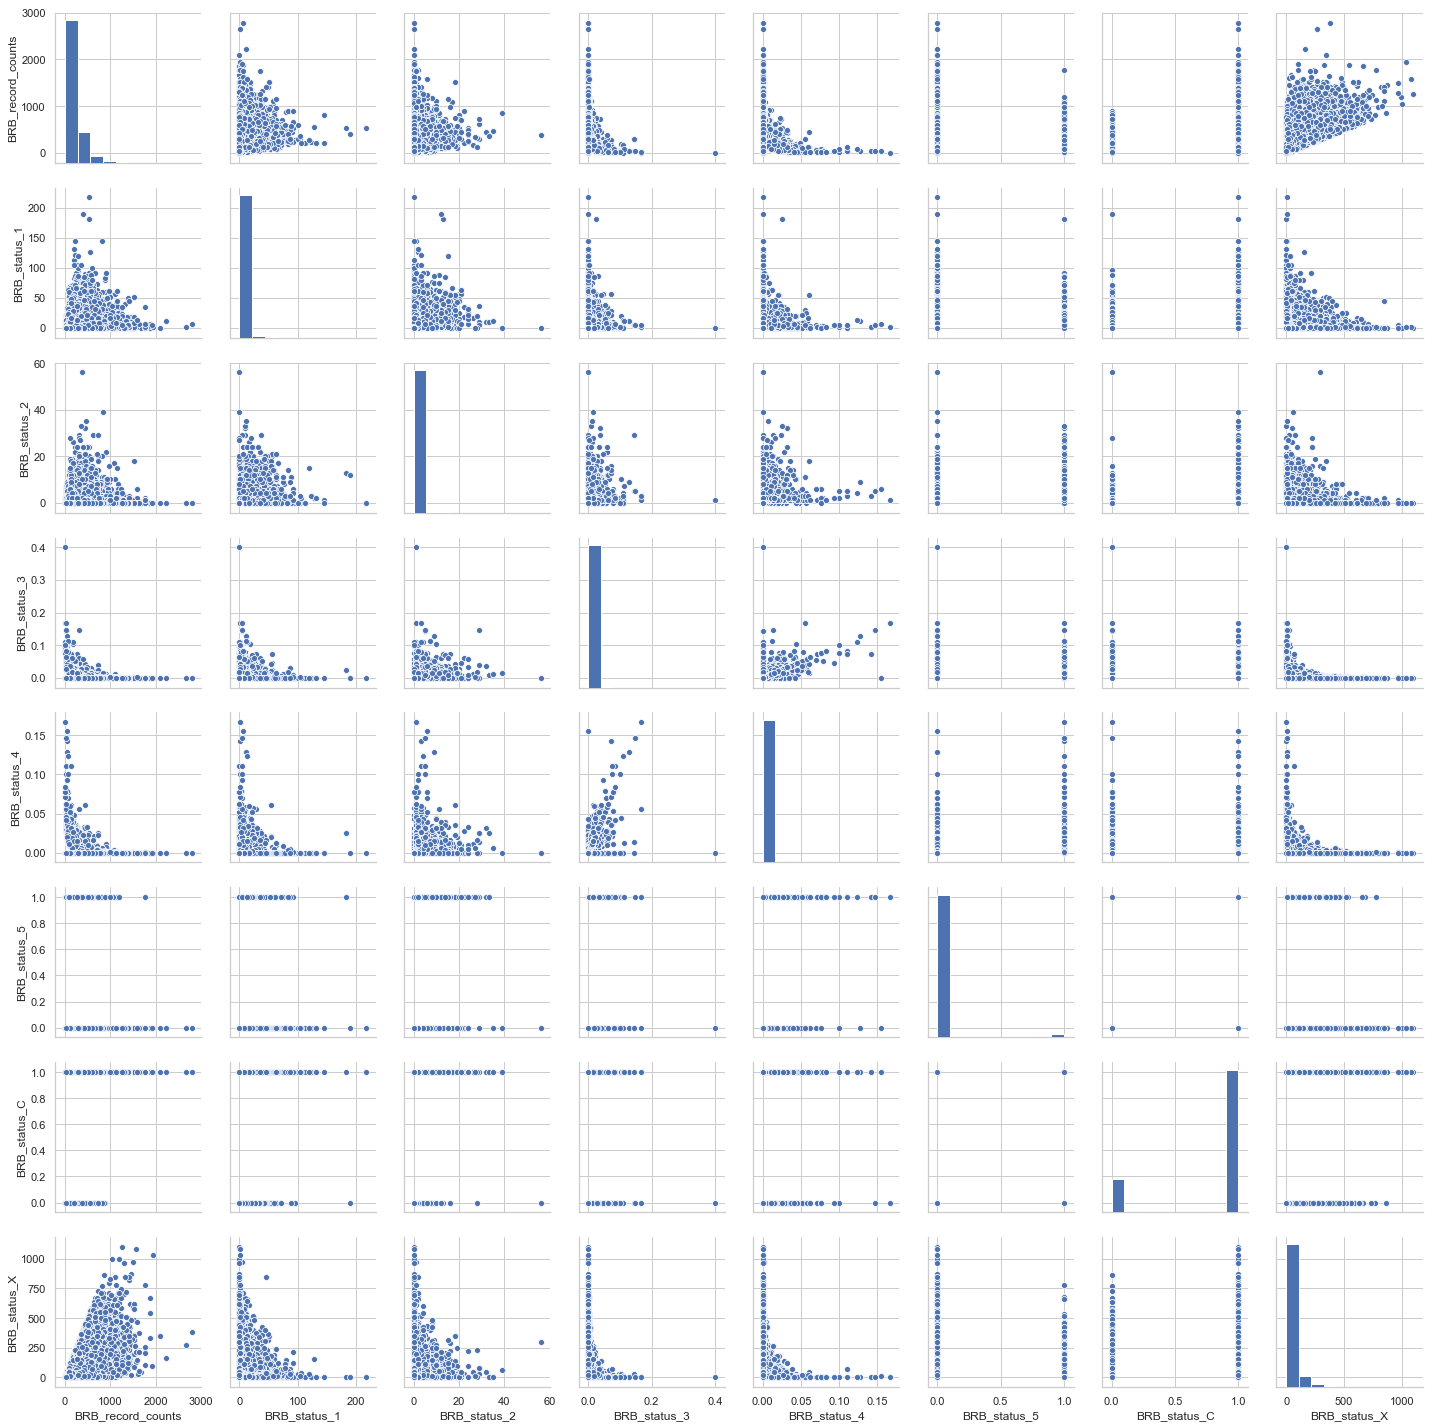

In [53]:
# Outlook of each pair
sns.pairplot(bureau_bal_agg.drop('SK_ID_CURR', axis = 1))
plt.show()

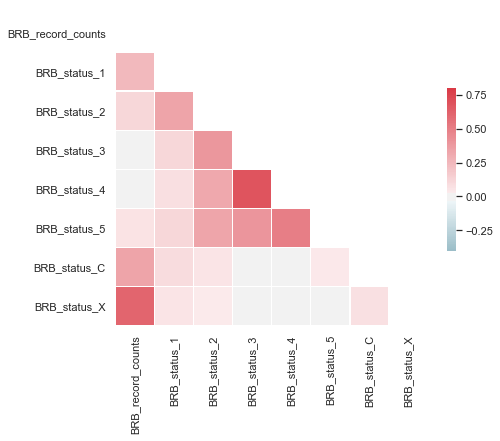

In [54]:
# Correlation matrix
corr = bureau_bal_agg.drop('SK_ID_CURR', axis = 1).corr()

# Plot heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (7, 6))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,vmin = -.4, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
plt.show()

### Installment payments

In [55]:
# First few rows
inst_payment.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [56]:
# Missing percentages
get_na_percent(inst_payment).sort_values('na_percent', ascending = False).head()

,na_percent
variable,
DAYS_ENTRY_PAYMENT,0.021352
AMT_PAYMENT,0.021352
SK_ID_PREV,0.000000
SK_ID_CURR,0.000000
NUM_INSTALMENT_VERSION,0.000000


In [57]:
# Drop the rows with no SK_ID_CURR
inst_payment = inst_payment.dropna(axis = 0)
inst_payment.shape

(13602496, 8)

In [58]:
# Summary
inst_payment.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis = 1).describe()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360250e+07,1.360250e+07,1.360250e+07,1.360250e+07,1.360250e+07,1.360250e+07
mean,8.564952e-01,1.886637e+01,-1.042326e+03,-1.051114e+03,1.705107e+04,1.723822e+04
std,1.031683e+00,2.666131e+01,8.009456e+02,8.005859e+02,5.056866e+04,5.473578e+04
min,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.227660e+03,3.398265e+03
50%,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884710e+03,8.125515e+03
75%,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,7.300000e+01,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [59]:
start = timeit.default_timer()
# List of current IDs
curr_ids = inst_payment.SK_ID_CURR.unique()

# Empty lists
IP_record_counts = np.empty(len(curr_ids))     
IP_num_version_mean = np.empty(len(curr_ids))       
IP_num_install_mean = np.empty(len(curr_ids))
IP_days_install_mean = np.empty(len(curr_ids))   
IP_days_entryPay_mean = np.empty(len(curr_ids))          
IP_amt_install_mean = np.empty(len(curr_ids))   
IP_amt_payment_mean = np.empty(len(curr_ids))   

# Computing
for i in range(len(curr_ids)):
    cid = curr_ids[i]
    subset = inst_payment[inst_payment.SK_ID_CURR == cid]
    IP_record_counts[i] = len(subset.SK_ID_PREV)
    IP_num_version_mean[i] = np.mean(subset.NUM_INSTALMENT_VERSION)
    IP_num_install_mean[i] = np.mean(subset.NUM_INSTALMENT_NUMBER)
    IP_days_install_mean[i] = np.mean(subset.DAYS_INSTALMENT)
    IP_days_entryPay_mean[i] = np.mean(subset.DAYS_ENTRY_PAYMENT)
    IP_amt_install_mean[i] = np.mean(subset.AMT_INSTALMENT)
    IP_amt_payment_mean = np.mean(subset.AMT_PAYMENT)
    
inst_payment_agg = pd.DataFrame({'SK_ID_CURR': curr_ids,
                                 'IP_record_counts': IP_record_counts,
                                 'IP_num_version_mean': IP_num_version_mean,
                                 'IP_num_install_mean': IP_num_install_mean,
                                 'IP_days_install_mean': IP_days_install_mean,
                                 'IP_days_entryPay_mean': IP_days_entryPay_mean,
                                 'IP_amt_install_mean': IP_amt_install_mean,
                                 'IP_amt_payment_mean': IP_amt_payment_mean})
stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 1 hours 46 minutes37 seconds


In [60]:
# First few rows of the aggregated data
inst_payment_agg.head()

,IP_amt_install_mean,IP_amt_payment_mean,IP_days_entryPay_mean,IP_days_install_mean,IP_num_install_mean,IP_num_version_mean,IP_record_counts,SK_ID_CURR
0,12600.013812,55493.055,-1037.544554,-1026.643564,10.207921,1.039604,101.0,161674
1,10027.751582,55493.055,-1330.822785,-1327.765823,37.784810,0.360759,158.0,151639
2,11483.070000,55493.055,-35.000000,-40.333333,1.333333,2.666667,3.0,193053
3,20401.190000,55493.055,-1116.370370,-1117.037037,12.481481,1.111111,27.0,199697
4,4114.450500,55493.055,-1198.400000,-1190.600000,5.000000,1.100000,30.0,167756


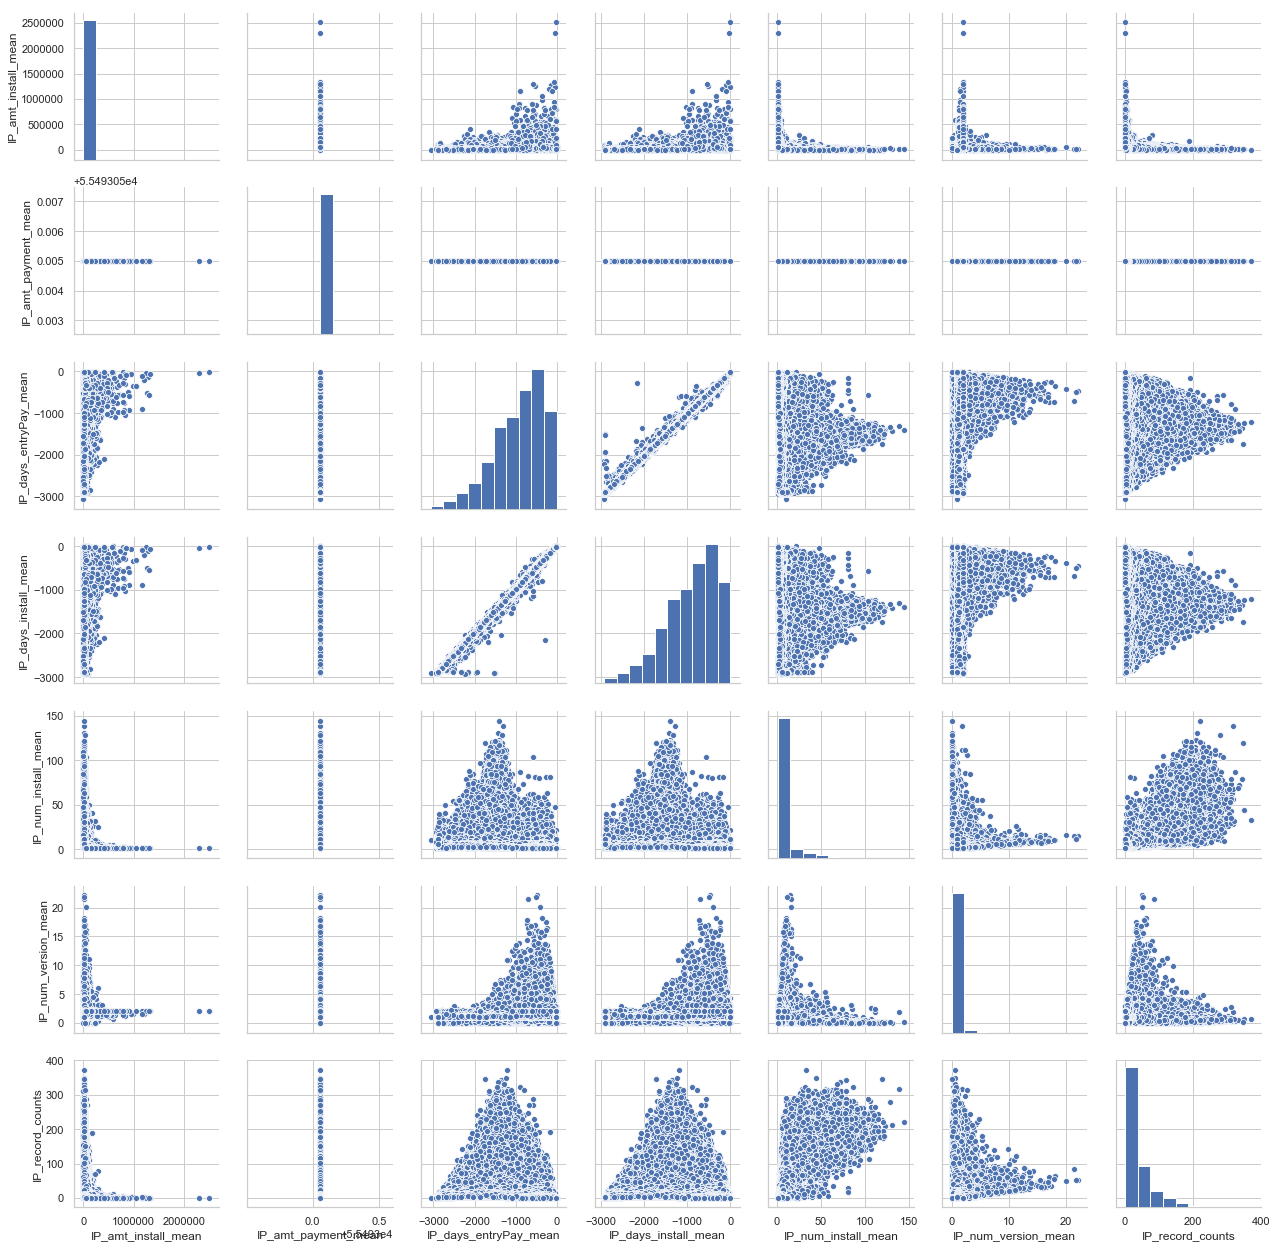

In [61]:
# Outlook of each pair
sns.pairplot(inst_payment_agg.drop('SK_ID_CURR', axis = 1))
#plt.savefig('inst_payment_agg_pairs.png')
plt.show()

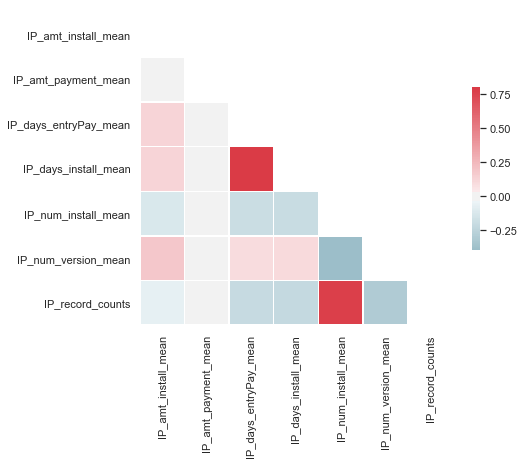

In [62]:
# Correlation matrix
corr = inst_payment_agg.drop('SK_ID_CURR', axis = 1).corr()

# Plot heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (7, 6))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,vmin = -.4, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
#plt.savefig('inst_payment_agg_corr.png')
plt.show()

### POS cash balance

In [63]:
# First few rows
pos_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [64]:
# Missing percentages
get_na_percent(pos_bal).sort_values('na_percent', ascending = False).head()

,na_percent
variable,
CNT_INSTALMENT_FUTURE,0.260835
CNT_INSTALMENT,0.260675
SK_ID_PREV,0.000000
SK_ID_CURR,0.000000
MONTHS_BALANCE,0.000000


In [65]:
# Drop the rows with missing and NAME_CONTRACT_STATUS column
pos_bal = pos_bal.dropna(axis = 0)
pos_bal = pos_bal.drop('NAME_CONTRACT_STATUS', axis = 1)
pos_bal.shape

(9975174, 7)

In [66]:
# Summary
pos_bal.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis = 1).describe()

,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,9.975174e+06,9.975174e+06,9.975174e+06,9.975174e+06,9.975174e+06
mean,-3.505663e+01,1.708974e+01,1.048380e+01,1.163740e+01,6.561863e-01
std,2.608026e+01,1.199508e+01,1.110903e+01,1.328868e+02,3.280544e+01
min,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [67]:
# Aggregation
start = timeit.default_timer()
# List of current IDs
curr_ids = pos_bal.SK_ID_CURR.unique()

# Empty lists
POS_record_counts = np.empty(len(curr_ids))     
POS_month_bal_mean = np.empty(len(curr_ids))       
POS_cnt_inst_mean =np.empty(len(curr_ids))
POS_cnt_inst_future_mean = np.empty(len(curr_ids))   
POS_days_overdue_mean = np.empty(len(curr_ids))          
POS_overdue_tol_mean = np.empty(len(curr_ids))   

# Computing
for i in range(len(curr_ids)):
    cid = curr_ids[i]
    subset = pos_bal[pos_bal.SK_ID_CURR == cid]
    POS_record_counts[i] = len(subset.SK_ID_PREV)
    POS_month_bal_mean[i] = np.sum(subset.MONTHS_BALANCE)
    POS_cnt_inst_mean[i] = np.sum(subset.CNT_INSTALMENT)
    POS_cnt_inst_future_mean[i] = np.sum(subset.CNT_INSTALMENT_FUTURE)
    POS_days_overdue_mean[i] = np.mean(subset.SK_DPD)
    POS_overdue_tol_mean[i] = np.mean(subset.SK_DPD_DEF)
    
pos_bal_agg = pd.DataFrame({'SK_ID_CURR': curr_ids,
                               'POS_record_counts': POS_record_counts,
                               'POS_month_bal_mean': POS_month_bal_mean,
                               'POS_cnt_inst_mean': POS_cnt_inst_mean,
                               'POS_cnt_inst_future_mean': POS_cnt_inst_future_mean,
                               'POS_days_overdue_mean': POS_days_overdue_mean,
                               'POS_overdue_tol_mean': POS_overdue_tol_mean})
stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 20 hours 6 minutes41 seconds


In [68]:
# First few rows of the aggregated data
#pos_bal_agg.to_csv('pos_bal_agg.csv', index = False, header = True)
pos_bal_agg.head()

,POS_cnt_inst_future_mean,POS_cnt_inst_mean,POS_days_overdue_mean,POS_month_bal_mean,POS_overdue_tol_mean,POS_record_counts,SK_ID_CURR
0,1092.0,1674.0,0.000000,-1169.0,0.000000,43.0,182943
1,516.0,714.0,0.000000,-1111.0,0.000000,27.0,367990
2,1280.0,1988.0,37.706422,-4627.0,0.146789,109.0,397406
3,2473.0,3745.0,0.000000,-5228.0,0.000000,114.0,269225
4,1824.0,3150.0,0.000000,-4678.0,0.000000,126.0,334279


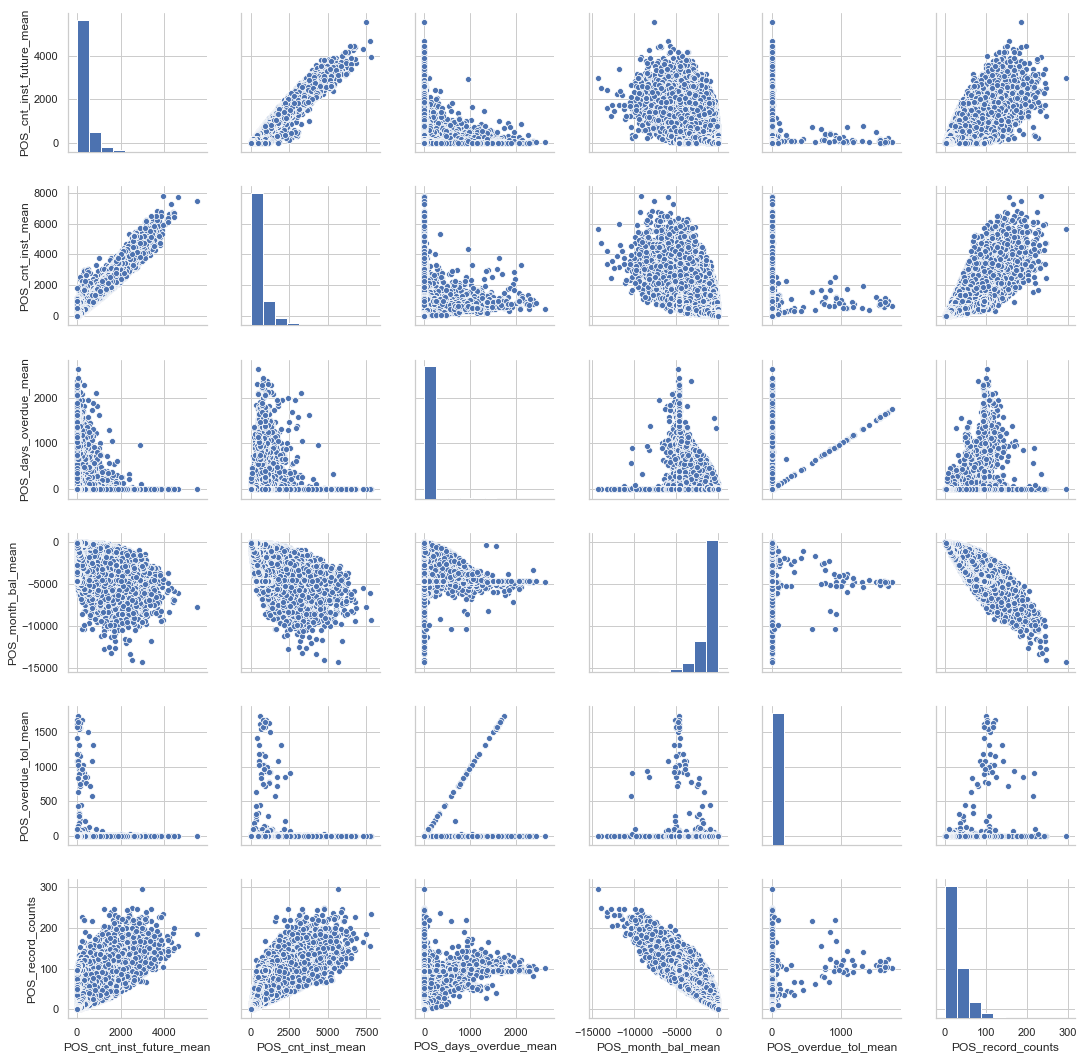

In [69]:
# Outlook of each pair
sns.pairplot(pos_bal_agg.drop('SK_ID_CURR', axis = 1))
#plt.savefig('pos_bal_agg_pairs.png')
plt.show()

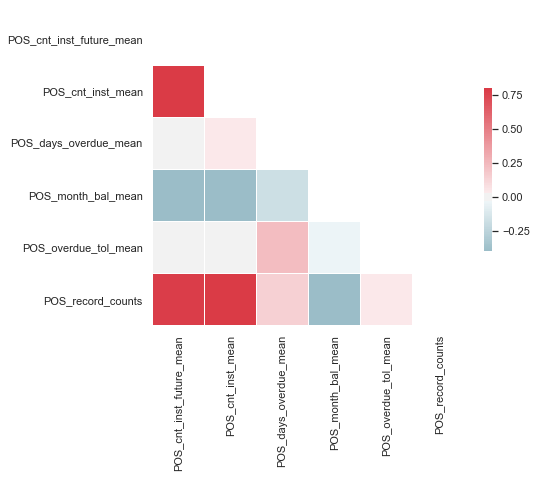

In [70]:
# Correlation matrix
corr = pos_bal_agg.drop('SK_ID_CURR', axis = 1).corr()

# Plot heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib plane
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (7, 6))

# Customise a diversing colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap,vmin = -.4, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.margins(.02)
plt.show()

### Feature engineering for application data

In [71]:
# Label encoding for 2-category variables 
le = LabelEncoder()

for col in application.columns:
    if application[col].dtype == 'object':
        if len(list(application[col].unique())) <= 2:
            le.fit(application[col])
            application[col] = le.transform(application[col])

In [72]:
# One-hot encoding for 3- or more-category variables
application = pd.get_dummies(application, drop_first = True)
application.shape

(307511, 293)

In [73]:
# Save feature names 
feature_names = application.columns.drop('TARGET')
variable_names = application.columns

# Split X and y
X = application.drop(['TARGET'], axis = 1)
y = application.TARGET

# Imputation
imputer = Imputer(strategy = 'median')
imputer.fit(X)
X_imputed = imputer.transform(X) #numpy.ndarray'

# Stnadardisation
scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(X_imputed)
X_normed = scaler.transform(X_imputed)

In [74]:
# Feature importance
etc = ExtraTreesClassifier()
etc.fit(X_normed, y)
score = pd.DataFrame({'Feature': feature_names, 'Score': etc.feature_importances_})
score.sort_values(by = ['Score'], ascending = False, inplace = True)

In [75]:
# Cut the score at 0.002
feature_fi = list(score.loc[score.Score >= .002].Feature)
k = score.loc[score.Score >= .002].shape[0]
score.loc[score.Score >= .002].shape

(134, 2)

In [76]:
score.loc[score.Score >= .002].head()

,Feature,Score
32,EXT_SOURCE_2,0.031184
33,EXT_SOURCE_3,0.028963
10,DAYS_BIRTH,0.020154
13,DAYS_ID_PUBLISH,0.019440
81,DAYS_LAST_PHONE_CHANGE,0.019139


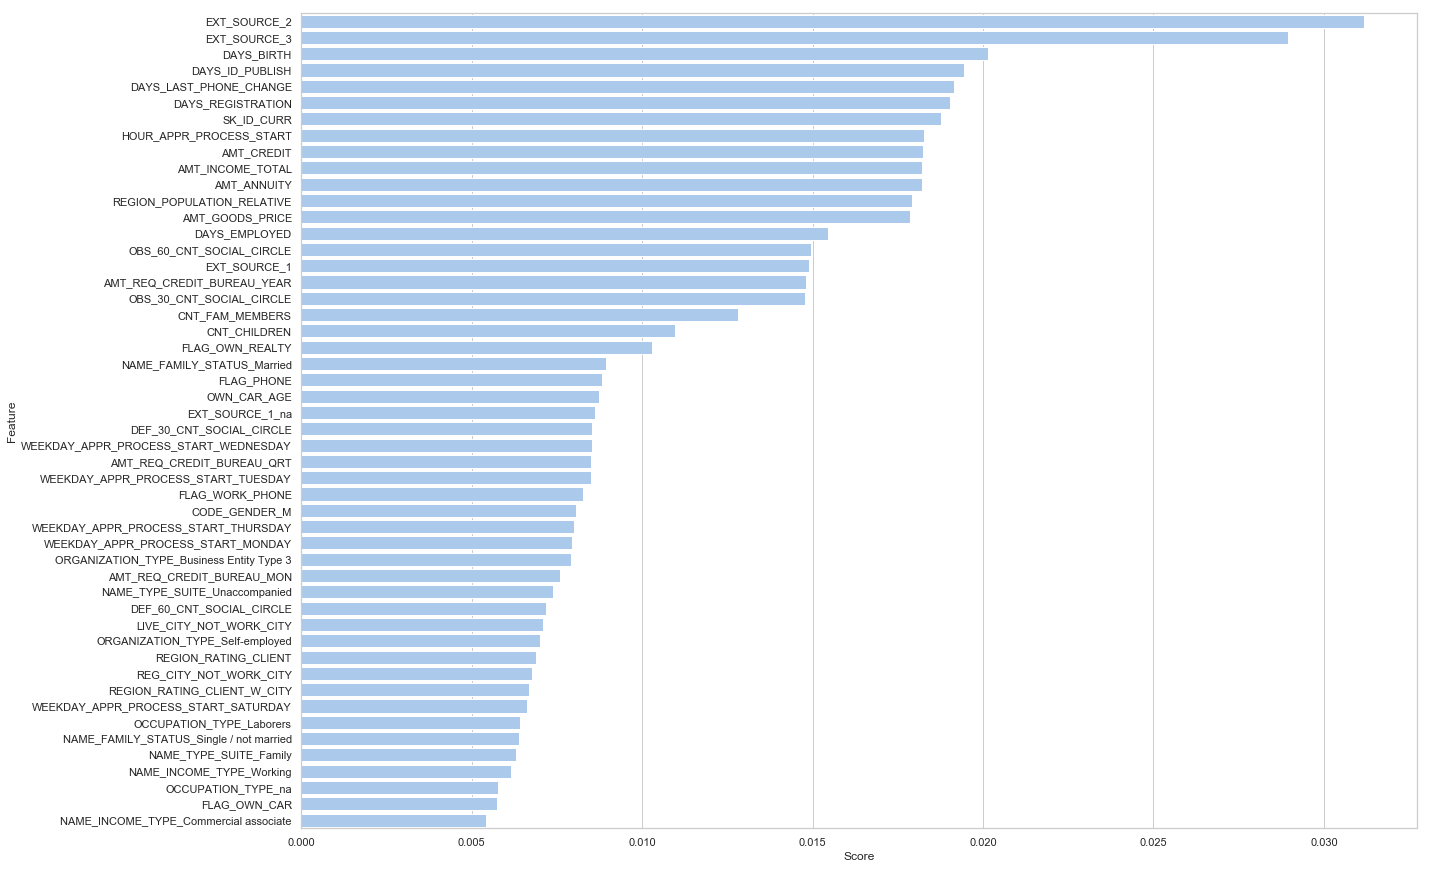

In [77]:
# Visualise the important feafures with its score
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (20, 15)) # initialise the matplot plane

score_top50 = score.iloc[:50]

# Plot 
_ = sns.set_color_codes('pastel')
_ = sns.barplot(x = 'Score', y = 'Feature', data = score_top50, color = 'b')
plt.show()

In [78]:
# Logistic Regression using k features from feature importance method
features = score.loc[score.Score >= .001].Feature

X_fi = X_normed[:, features.index]

lg = LogisticRegression()
lg.fit(X_fi, y)
pred_prob = lg.predict_proba(X_fi)[:, 1] #probability of prediction for TARGET==1

# positive rates and ROC-AUC score 
fpr_fi, tpr_fi, thresh_fi = roc_curve(y, pred_prob)
score_fi = roc_auc_score(y, pred_prob)
print('Score of feature importance method: {}'.format(score_fi))

Score of feature importance method: 0.7495863733426601


In [79]:
# Recursive feature elimination with k features as same as the earlier ones
start = timeit.default_timer()

lg = LogisticRegression()
rfe = RFE(lg, n_features_to_select = k)
rfe.fit(X_normed, y)
X_rfe = rfe.transform(X_normed)
pred_prob = rfe.predict_proba(X_normed)[:, 1]

stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 1 hours 23 minutes13 seconds


In [80]:
# Name of selected features
idxs_rfe = rfe.get_support(indices = True)
feature_rfe = feature_names[idxs_rfe]

# ROC-AUC score
fpr_rfe, tpr_rfe, thresh_rfe = roc_curve(y, pred_prob)
score_rfe = roc_auc_score(y, pred_prob)
print('Score of recursive feature elimination: {}'.format(score_rfe))

Score of recursive feature elimination: 0.7498561968475066


In [81]:
# Univariate selection with k features as same as the earlier ones
kbest = SelectKBest(score_func = chi2, k = k)
kbest.fit(X_normed, y)
X_kbest = kbest.transform(X_normed)

lg = LogisticRegression()
lg.fit(X_kbest, y)
pred_prob = lg.predict_proba(X_kbest)[:, 1]

# Name of selected features
idxs_kbest = kbest.get_support(indices=True)
feature_kbest = feature_names[idxs_kbest]

# ROC-AUC score
fpr_kbest, tpr_kbest, thresh_kbest = roc_curve(y, pred_prob)
score_kbest = roc_auc_score(y, pred_prob)
print('Score of univariate selection: {}'.format(score_kbest))

Score of univariate selection: 0.743618496024459


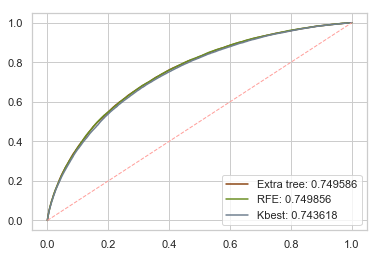

In [82]:
# Roc courves 
plt.figure(0).clf()
plt.plot(fpr_fi, tpr_fi, label = "Extra tree: " + str(round(score_fi, 6)), color = 'saddlebrown')
plt.plot(fpr_rfe, tpr_rfe, label = "RFE: " + str(round(score_rfe,6)), color = 'olivedrab')
plt.plot(fpr_kbest, tpr_kbest, label = "Kbest: "+ str(round(score_kbest,6)), color = 'slategray')
plt.plot([0, 1], [0, 1], color = 'r', linestyle = '--', linewidth = 1)
plt.legend(loc = 4)
#plt.savefig('ROC feature selection.png')
plt.show()

In [83]:
## Compare these three selections
# Union of all features
feature_all = list(set(feature_fi) | set(feature_rfe) | set(feature_kbest))
len(feature_all)

257

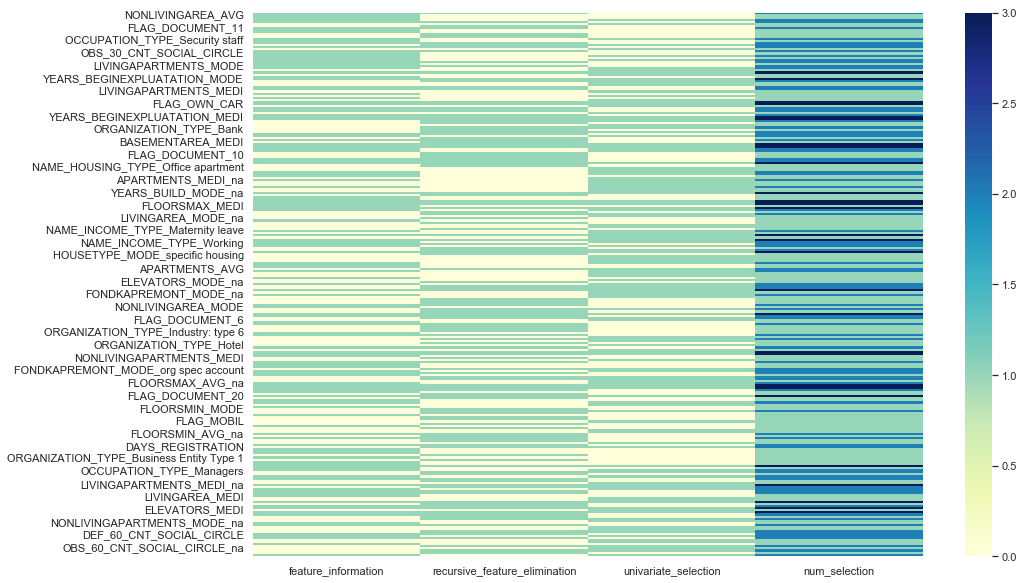

In [84]:
# Heatmap of selection
fi_flag = np.empty(len(feature_all))
rfe_flag = np.empty(len(feature_all))
kbest_flag = np.empty(len(feature_all))

for i in range(len(feature_all)):
    ff = feature_all[i]
    fi_flag[i] = np.where(ff in feature_fi, 1, 0)
    rfe_flag[i] = np.where(ff in feature_rfe, 1, 0)
    kbest_flag[i] = np.where(ff in feature_kbest, 1, 0)
        
feature_df = pd.DataFrame({'feature_imfortance': fi_flag, 
                           'recursive_feature_elimination': rfe_flag, 
                           'univariate_selection': kbest_flag})
feature_df.index = feature_all
feature_df['num_selection'] = feature_df.apply(np.sum, axis = 1)

plt.figure(figsize = (15, 10))
sns.heatmap(feature_df, cmap = 'YlGnBu')
plt.xticks(rotation = 0)
plt.show()

In [85]:
# Features selected with all three algorithms
feature_df.loc[(feature_df.feature_information == 1) & 
               (feature_df.recursive_feature_elimination == 1) & 
               (feature_df.univariate_selection == 1), :].index

Index(['REGION_RATING_CLIENT', 'EXT_SOURCE_3', 'FLAG_OWN_CAR',
       'ORGANIZATION_TYPE_School', 'EXT_SOURCE_2', 'OCCUPATION_TYPE_Drivers',
       'DAYS_ID_PUBLISH', 'NAME_EDUCATION_TYPE_Higher education',
       'ELEVATORS_AVG', 'ELEVATORS_MODE',
       'NAME_EDUCATION_TYPE_Secondary / secondary special', 'FLOORSMAX_MEDI',
       'OWN_CAR_AGE_na', 'EXT_SOURCE_1', 'NAME_INCOME_TYPE_State servant',
       'NAME_FAMILY_STATUS_Married', 'REGION_RATING_CLIENT_W_CITY',
       'EXT_SOURCE_1_na', 'DAYS_LAST_PHONE_CHANGE', 'FLOORSMAX_MODE',
       'FLAG_DOCUMENT_3', 'CODE_GENDER_M', 'ORGANIZATION_TYPE_Construction',
       'FLAG_WORK_PHONE', 'NAME_FAMILY_STATUS_Widow', 'REG_CITY_NOT_LIVE_CITY',
       'ELEVATORS_MEDI', 'AMT_GOODS_PRICE'],
      dtype='object')

### Modelling using all data together

In [86]:
# Record validation outcomes
labels = []
auc_scores = []
num_features = []

In [87]:
# Join tables
df = pd.merge(application, bureau_agg, how = 'left', on = 'SK_ID_CURR')
df = pd.merge(df, bureau_bal_agg, how = 'left', on = 'SK_ID_CURR')
df = pd.merge(df, cc_bal_agg, how = 'left', on = 'SK_ID_CURR')
df = pd.merge(df, inst_payment_agg, how = 'left', on = 'SK_ID_CURR')
df = pd.merge(df, pos_bal_agg, how = 'left', on = 'SK_ID_CURR')

# Impute missing with zeros
df = df.fillna(0)
df.shape

(307511, 330)

In [115]:
# Split data into feature and target --> normalise features
df_features = df.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
df_target = df.TARGET

scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(df_features)
df_normed = scaler.transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(df_normed, df_target, test_size = .3, random_state = 2018)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(215257, 328) (92254, 328) (215257,) (92254,)


In [89]:
# ROC AUC score without hyper paramer tuning
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
probs = log_reg.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, probs)
fpr_0, tpr_0, threshholds_0 = roc_curve(y_test, probs)

labels.append('logreg_default')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score for default logistic regression: {}'.format(score))

AUC score for default logistic regression: 0.7519957195581091


In [90]:
# RandomizedRearchCV for params of LogisticRegression
start = timeit.default_timer()

penalty_space = ['l1', 'l2']
tol_space = [1e-3, 1e-4, 1e-5]
C_space = [0.001, 1, 100]
param_grid = {'penalty': penalty_space, 'tol': tol_space, 'C': C_space}

log_reg = LogisticRegression()
cross_val = RandomizedSearchCV(log_reg, param_grid, cv = 5, scoring = 'roc_auc')
cross_val.fit(X_train, y_train)

finish = timeit.default_timer()
print('Computing time: {}'.format(hms(finish - start)))

Computing time: 1 hours 59 minutes19 seconds


In [91]:
# Best result
print('Best estimator: {}'.format(cross_val.best_estimator_),
      '\nBest score: {}'.format(cross_val.best_score_),
      '\nBest params: {}'.format(cross_val.best_params_))

Best estimator: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False) 
Best score: 0.7592512757341408 
Best params: {'tol': 1e-05, 'penalty': 'l2', 'C': 100}


In [119]:
# ROC AUC score with hyper paramer tuning for all features
log_reg.fit(X_train, y_train)

probs = log_reg.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, probs)
fpr_1, tpr_1, threshholds_1 = roc_curve(y_test, probs)

labels.append('logreg_cv_all_features')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score of logistic regression for all features: {}'.format(score))

AUC score of logistic regression for all features: 0.7536538697407735


In [94]:
# Feature importance
feature_names = df_features.columns
etc = ExtraTreesClassifier()
etc.fit(df_normed, df_target)
feature_score = pd.DataFrame({'Feature': feature_names, 'Score': etc.feature_importances_})
feature_score.sort_values(by = ['Score'], ascending = False, inplace = True)
feature_score.head()

,Feature,Score
31,EXT_SOURCE_2,0.023227
32,EXT_SOURCE_3,0.016730
9,DAYS_BIRTH,0.012906
318,IP_days_install_mean,0.012236
315,IP_amt_install_mean,0.012226


In [95]:
# Cut the score at 0.001
features_1 = list(feature_score.loc[feature_score.Score >= .001].Feature)
k = feature_score.loc[feature_score.Score >= .001].shape[0]
feature_score.loc[feature_score.Score >= .001].shape

(206, 2)

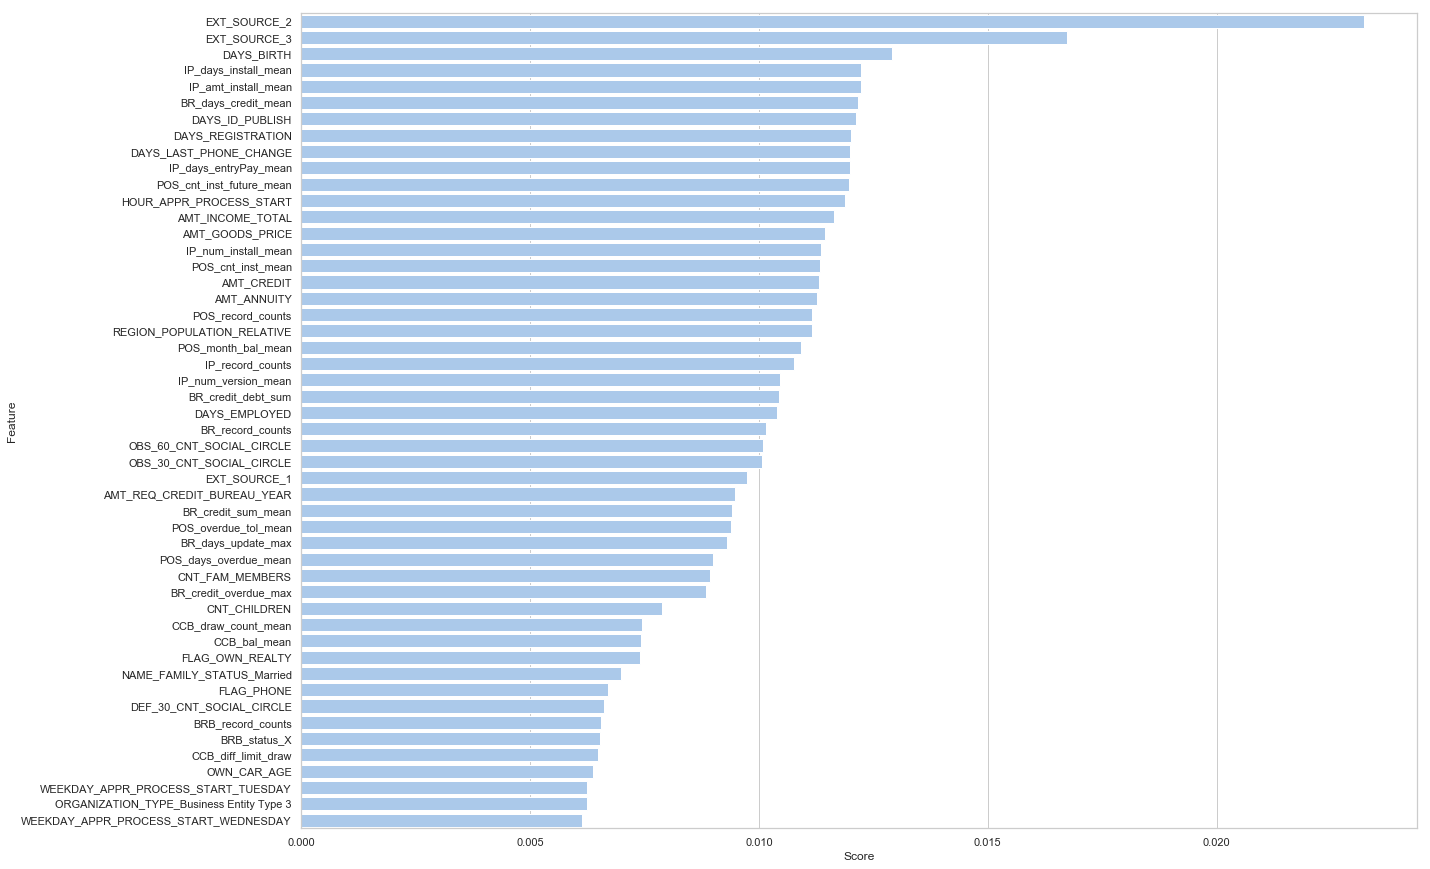

In [96]:
# Visualise the important feafures with its score
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (20, 15)) # initialise the matplot plane

score_top50 = feature_score.iloc[:50]

# Plot 
_ = sns.set_color_codes('pastel')
_ = sns.barplot(x = 'Score', y = 'Feature', data = score_top50, color = 'b')
plt.show()

In [97]:
# Split data into feature and target --> normalise features
df_features = df_features[features_1]
df_target = df_target

scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(df_features)
df_normed = scaler.transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(df_normed, df_target, test_size = .3, random_state = 2018)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(215257, 206) (92254, 206) (215257,) (92254,)


In [98]:
# RandomizedRearchCV for params of LogisticRegression
start = timeit.default_timer()

penalty_space = ['l1', 'l2']
tol_space = [1e-3, 1e-4, 1e-5]
C_space = [0.001, 1, 100]
param_grid = {'penalty': penalty_space, 'tol': tol_space, 'C': C_space}

log_reg = LogisticRegression()
cross_val = RandomizedSearchCV(log_reg, param_grid, cv = 5, scoring = 'roc_auc')
cross_val.fit(X_train, y_train)

finish = timeit.default_timer()
print('Computing time: {}'.format(hms(finish - start)))

Computing time: 2 hours 47 minutes15 seconds


In [99]:
# Best result
print('Best estimator: {}'.format(cross_val.best_estimator_),
      '\nBest score: {}'.format(cross_val.best_score_),
      '\nBest params: {}'.format(cross_val.best_params_))

Best estimator: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False) 
Best score: 0.7593318896529478 
Best params: {'tol': 1e-05, 'penalty': 'l2', 'C': 100}


In [101]:
# Apply the best params in LogisticRegression
log_reg.fit(X_train, y_train)

probs = log_reg.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, probs)
fpr_2, tpr_2, threshholds_2 = roc_curve(y_test, probs)

labels.append('logreg_cv_features_1')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score for LogReg with features: {}'.format(score))

AUC score for LogReg with features: 0.752087988047049


In [102]:
# Cut the score at 0.002
features_2 = list(feature_score.loc[feature_score.Score >= .002].Feature)
k = feature_score.loc[feature_score.Score >= .002].shape[0]
feature_score.loc[feature_score.Score >= .002].shape

(152, 2)

In [103]:
# Split data into feature and target --> normalise features
df_features = df_features[features_2]
df_target = df_target

scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(df_features)
df_normed = scaler.transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(df_normed, df_target, test_size = .3, random_state = 2018)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(215257, 152) (92254, 152) (215257,) (92254,)


In [104]:
start = timeit.default_timer()
# RandomizedRearchCV for params of LogisticRegression
penalty_space = ['l1', 'l2']
tol_space = [1e-3, 1e-4, 1e-5]
C_space = [0.001, 1, 100]
param_grid = {'penalty': penalty_space, 'tol': tol_space, 'C': C_space}

log_reg = LogisticRegression()
cross_val = RandomizedSearchCV(log_reg, param_grid, cv = 5, scoring = 'roc_auc')
cross_val.fit(X_train, y_train)

finish = timeit.default_timer()
print('Computing time: {}'.format(hms(finish - start)))

Computing time: 21 hours 16 minutes31 seconds


In [105]:
# Best result
print('Best estimator: {}'.format(cross_val.best_estimator_),
      '\nBest score: {}'.format(cross_val.best_score_),
      '\nBest params: {}'.format(cross_val.best_params_))

Best estimator: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False) 
Best score: 0.7579081618546183 
Best params: {'tol': 1e-05, 'penalty': 'l1', 'C': 100}


In [106]:
# Apply the best params in LogisticRegression
log_reg.fit(X_train, y_train)

probs = log_reg.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, probs)
fpr_3, tpr_3, threshholds_3 = roc_curve(y_test, probs)

labels.append('logreg_cv_features_2')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score for LogReg with features: {}'.format(score))

AUC score for LogReg with features: 0.7509476116076559


In [107]:
# Light GBM
lgbm = LGBMClassifier()
param_0 = lgbm.get_params()
param_0

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [108]:
# Split data into feature and target --> normalise features
df_features = df.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
df_target = df.TARGET

scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(df_features)
df_normed = scaler.transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(df_normed, df_target, test_size = .3, random_state = 2018)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(215257, 328) (92254, 328) (215257,) (92254,)


In [109]:
# Fit the model and predict
lgbm.fit(X_train, y_train)
probs = lgbm.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, probs)
fpr_4, tpr_4, threshholds_4 = roc_curve(y_test, probs)

labels.append('lgbm_all_features')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score of LGBM for all features: {}'.format(score))

AUC score of LGBM for all features: 0.7679486108237442


In [110]:
# Features with importance level of over 0.001
df_features = df[features_1]
df_target = df_target

scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(df_features)
df_normed = scaler.transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(df_normed, df_target, test_size = .3, random_state = 2018)

# Fit the model and predict
lgbm.fit(X_train, y_train)
probs = lgbm.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, probs)
fpr_5, tpr_5, threshholds_5 = roc_curve(y_test, probs)

labels.append('lgbm_features_1')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score of LGBM for all features: {}'.format(score))

AUC score of LGBM for all features: 0.7673156029161624


In [111]:
# Features with importance level of over 0.002
df_features = df[features_2]
df_target = df_target

scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(df_features)
df_normed = scaler.transform(df_features)
X_train, X_test, y_train, y_test = train_test_split(df_normed, df_target, test_size = .3, random_state = 2018)

# Fit the model and predict
lgbm.fit(X_train, y_train)
preds = lgbm.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, preds)
fpr_6, tpr_6, threshholds_6 = roc_curve(y_test, probs)

labels.append('lgbm_features_2')
auc_scores.append(score)
num_features.append(X_train.shape[1])

print('AUC score of LGBM for all features: {}'.format(score))

AUC score of LGBM for all features: 0.7675125266746043


In [134]:
# Score tables
score_tab = pd.DataFrame({'Label': labels, 'Score': auc_scores, 'Num_features': num_features})
#score_tab.to_csv('auc_scores_final.csv', header = True)
score_tab

,Label,Num_features,Score
0,logreg_default,328,0.751996
1,logreg_cv_all_features,328,0.753654
2,logreg_cv_features_1,206,0.752088
3,logreg_cv_features_2,152,0.750948
4,lgbm_all_features,328,0.767949
5,lgbm_features_1,206,0.767316
6,lgbm_features_2,152,0.767513


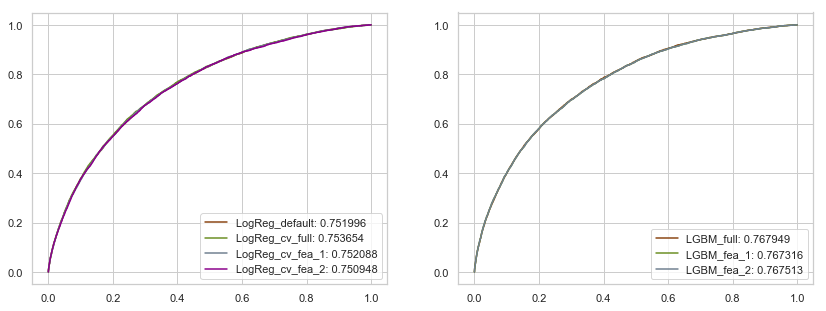

In [133]:
# Roc courves 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr_0, tpr_0, label = "LogReg_default: " + \
             str(round(score_tab.Score[0], 6)), color = 'saddlebrown')
axes[0].plot(fpr_1, tpr_1, label = "LogReg_cv_full: " + \
             str(round(score_tab.Score[1], 6)), color = 'olivedrab')
axes[0].plot(fpr_2, tpr_2, label = "LogReg_cv_fea_1: "+ \
             str(round(score_tab.Score[2], 6)), color = 'slategray')
axes[0].plot(fpr_3, tpr_3, label = "LogReg_cv_fea_2: "+ \
             str(round(score_tab.Score[3], 6)), color = 'darkmagenta')
axes[0].legend(loc = 0)

axes[1].plot(fpr_4, tpr_4, label = "LGBM_full: " + \
             str(round(score_tab.Score[4], 6)), color = 'saddlebrown')
axes[1].plot(fpr_5, tpr_5, label = "LGBM_fea_1: " + \
             str(round(score_tab.Score[5], 6)), color = 'olivedrab')
axes[1].plot(fpr_6, tpr_6, label = "LGBM_fea_2: "+ \
             str(round(score_tab.Score[6], 6)), color = 'slategray')
axes[1].legend(loc = 4)

#plt.savefig('ROC logreg and LGBM.png')
plt.show()